In [1]:
# Config Variables

# Define UCI Datasets to pull
# https://archive.ics.uci.edu/ml/datasets.php
uci_datasets = [165]

# Use all data (vs just training data) for OLS to determine co-efficient sign
ols_use_all_data = True

# Training set sizes to use (only training set sizes < 60% of total dataset size will be used)
training_set_sizes = [10, 40, 160, 610, 2560, 10240, 40960]
chain_lengths = [20000, 20000, 100000, 100000, 100000, 100000, 100000]

# Number of etas (prior standard deviation) to test between 1e-04 and 1e05 (recommend 20)
# Limits at 0 and infinity are calculated separately
# Note: In practice, sigma^2 (likelihood variance) is set to 1/eta^2 and
#       lambda (penalty) is set to 1/eta^4 
num_etas = 20

# Number of folds for cross-validation (set to 300 in 2018 paper, recommend testing with 5 to see if it works)
cv_folds = 5

# Overwrite model if it's already saved to file
overwrite_model = False

In [2]:
# Load necessary libraries and helper functions

# import helper functions from helpers/data_manipulation.py
from helpers.data_manipulation import *

# import half_ridge functions from helpers/half_ridge.py
from helpers.half_ridge import *

# import dataset class
from helpers.model import Model

# import os and pickle
import os
import pickle
 
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns
import time

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

# PyMC3 for Bayesian Inference
import arviz as az
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Load the ICU dataset, normalize the data, and split into training, validation, and test sets

# Loop over each dataset, loaded from file and formatted
for dataset in uci_datasets:
    model = Model()
    model.import_from_file('uci_ml_datasets/ucirepo_' + str(dataset) + '.csv')
    model.format_data()
    training_set_values = model.set_up_training_values(training_set_sizes, .6)

    print(training_set_values)
    
    # Initialize the comparison results
    binary_comparisons = {}

    # loop over the training set values
    for training_set_index, training_set_value in enumerate(training_set_values):
        print(f"Training Set Index: {training_set_index}, Training Set Value: {training_set_value}")

        # Check if a file exists for the dataset in the dataset_models folder
        # if it does, skip the rest of the code and continue with the loop
        # if it doesn't, continue with the rest of the code
        if os.path.isfile(f"models/uci_repo_{dataset}/{training_set_value}.csv") and not overwrite_model:
            print(f"Model already exists for dataset {dataset} and training_set_value {training_set_value}. Skipping...")
            continue

        # Generate cross-validation indices
        cv = cv_indexing(cv_folds, model.X.shape[0], training_set_value)

        # Initialize the comparison results for this training set value
        binary_comparisons[training_set_value] = {}

        # Vary eta values from 10^-4 to 10^5 and loop over them
        etas = np.logspace(-4, 5, num=num_etas)
        etas = np.insert(etas, 0, 0)
        etas = np.append(etas, np.inf)
        for eta in etas:

            # Initialize the comparison results for this eta
            binary_comparisons[training_set_value][eta] = []

            # Crossvalidate over the folds for a specific tau
            for i in range(cv_folds):

                # Print info about this iteration
                print(f"Training Set Value: {training_set_value}, Eta: {eta}, Fold: {i} of {range(cv_folds)}")

                # Get training and test indices for the i-th fold
                train_indices = np.where(cv[i] == 1)[0]
                test_indices = np.where(cv[i] == 0)[0]
                
                # Split the data
                X_train, X_test = model.X.iloc[train_indices], model.X.iloc[test_indices]
                y_train, y_test = model.y.iloc[train_indices], model.y.iloc[test_indices]

                # Determine the signs of the coefficients using OLS
                ols_coefficients = model.determine_signs_of_coefficients(ols_use_all_data, X_train, y_train)

                # Run the half ridge regression with mcmc
                #half_ridge_trace = half_ridge(X_train, y_train, model.ols_coefficients, prior_eta=eta)
                #var_dict = {}
                #for variable in half_ridge_trace.posterior:
                #    var_dict[variable] = half_ridge_trace.posterior[variable].values.flatten()
                # Results into a dataframe
                #var_weights = pd.DataFrame(var_dict)
                # Means for all the weights
                #var_means_array = var_weights.mean(axis=0)
                # Convert the dataframe var_means_array to a dictionary with the column names as keys
                #half_ridge_coefficients = {col: var_means_array[col] for col in var_weights.columns}
                
                # Run the half ridge regression with rejection sampling
                start_time = time.time()
                half_ridge_coefficients = half_ridge_rejection_sampling(ols_coefficients, X_train, y_train, eta, chain_lengths[training_set_index])
                end_time = time.time()
                duration = end_time - start_time
                print(f"Half ridge regression rejection sampling took {duration} seconds")

                # Calculate the binary comparisons for the models
                sorted_half_ridge_coefficients = {k: half_ridge_coefficients[k] for k in sorted(half_ridge_coefficients)}
                sorted_half_ridge_coefficients['intercept'] = 0
                print('half-ridge coefficients')
                print(sorted_half_ridge_coefficients)
                binary_comparison = calculate_binary_comparison(sorted_half_ridge_coefficients, X_test, y_test)
                binary_comparisons[training_set_value][eta].append(binary_comparison)
                print('binary comparisons')
                print(binary_comparison)   

    with open('models/ucirepo_' + str(dataset) + '.csv', 'wb') as file:
        pickle.dump(binary_comparisons, file)


[10, 40, 160, 610]
Training Set Index: 0, Training Set Value: 10
Training Set Value: 10, Eta: 0.0, Fold: 0 of range(0, 5)
Running half-ridge regression...
{'Cement': 0.7978845608028654, 'Superplasticizer': -0.7978845608028654, 'Age': -0.7978845608028654, 'Water': -0.7978845608028654, 'Fine Aggregate': -0.7978845608028654, 'Coarse Aggregate': -0.7978845608028654, 'Blast Furnace Slag': -0.7978845608028654, 'Fly Ash': -0.7978845608028654}
Half ridge regression rejection sampling took 7.033348083496094e-05 seconds
half-ridge coefficients
{'Age': -0.7978845608028654, 'Blast Furnace Slag': -0.7978845608028654, 'Cement': 0.7978845608028654, 'Coarse Aggregate': -0.7978845608028654, 'Fine Aggregate': -0.7978845608028654, 'Fly Ash': -0.7978845608028654, 'Superplasticizer': -0.7978845608028654, 'Water': -0.7978845608028654, 'intercept': 0}
binary comparisons
0.46
Training Set Value: 10, Eta: 0.0, Fold: 1 of range(0, 5)
Running half-ridge regression...
{'Cement': 0.7978845608028654, 'Superplastici

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.703
Training Set Value: 10, Eta: 1.8329807108324339, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.006690502166748047 seconds
half-ridge coefficients
{'Age': -0.15044696865679263, 'Blast Furnace Slag': -1.9536993971058199, 'Cement': 1.195516786507513, 'Coarse Aggregate': -0.7098744191294153, 'Fine Aggregate': -4.02170702758751, 'Fly Ash': -0.1794007489733467, 'Superplasticizer': -1.1402645486531087, 'Water': -3.0076543621831724, 'intercept': 0}
binary comparisons
0.588
Training Set Value: 10, Eta: 1.8329807108324339, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.00676274299621582 seconds
half-ridge coefficients
{'Age': -0.11756158318110099, 'Blast Furnace Slag': -0.33756943000911277, 'Cement': 0.21575045413455185, 'Coarse Aggregate': -0.8857297678603572, 'Fine Aggregate': -0.48581294051801327, 'Fly Ash': -0.36233078768938065, 'Superplasticizer': -0.10

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.691
Training Set Value: 10, Eta: 5.455594781168514, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03320646286010742 seconds
half-ridge coefficients
{'Age': 0.6985349117448929, 'Blast Furnace Slag': -0.11900582806200281, 'Cement': 1.5089065782131243, 'Coarse Aggregate': 0.7425795608693303, 'Fine Aggregate': -1.3049627621611073, 'Fly Ash': 0.7601170841734838, 'Superplasticizer': -0.0073350442032962225, 'Water': -0.5059854869612874, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.564
Training Set Value: 10, Eta: 5.455594781168514, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04003119468688965 seconds
half-ridge coefficients
{'Age': 0.7310515551958464, 'Blast Furnace Slag': 0.6335220189077295, 'Cement': 1.3134598330863216, 'Coarse Aggregate': 0.3112388259193855, 'Fine Aggregate': 0.1279101974391324, 'Fly Ash': 0.6284153843700218, 'Superplasticizer': 0.036387043122961336, 'Water': -0.40946605968088623, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.588
Training Set Value: 10, Eta: 5.455594781168514, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04361772537231445 seconds
half-ridge coefficients
{'Age': 1.3838093925288308, 'Blast Furnace Slag': -1.1119936169382025, 'Cement': -0.8145366651997463, 'Coarse Aggregate': -0.850331393778019, 'Fine Aggregate': -1.3209710816758744, 'Fly Ash': -0.35843513243788716, 'Superplasticizer': -0.79697810221261, 'Water': -1.382448946938178, 'intercept': 0}
binary comparisons
0.701
Training Set Value: 10, Eta: 5.455594781168514, Fold: 4 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.013055801391601562 seconds
half-ridge coefficients
{'Age': -0.03779689418368018, 'Blast Furnace Slag': -0.10377233622265636, 'Cement': 0.9876108945589654, 'Coarse Aggregate': -1.2451486179574924, 'Fine Aggregate': -0.8739187028135903, 'Fly Ash': -0.11828968363483594, 'Superplasticizer': -1.1508295642181443, 'Water': -1.6437104506772586, 'intercept': 0}
binary comparisons
0.642
Training Set Value: 10, Eta: 16.23776739188721, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03366208076477051 seconds
half-ridge coefficients
{'Age': 0.2142100006489475, 'Blast Furnace Slag': -1.8242917736053172, 'Cement': -1.866821191995299, 'Coarse Aggregate': -1.544566620964802, 'Fine Aggregate': -1.7503304516529032, 'Fly Ash': -2.276126922266288, 'Superplasticizer': 0.2303211947651406, 'Water': -1.9705464291028407, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.675
Training Set Value: 10, Eta: 16.23776739188721, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0322415828704834 seconds
half-ridge coefficients
{'Age': 0.6989624672425127, 'Blast Furnace Slag': -0.12054034363572784, 'Cement': 1.5076817561386144, 'Coarse Aggregate': 0.7409942119230126, 'Fine Aggregate': -1.30732718611311, 'Fly Ash': 0.7592524068772354, 'Superplasticizer': -0.007400696661175759, 'Water': -0.5076121380355826, 'intercept': 0}
binary comparisons
0.559
Training Set Value: 10, Eta: 16.23776739188721, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.038741350173950195 seconds
half-ridge coefficients
{'Age': 0.7298875576343057, 'Blast Furnace Slag': 0.6328088015017299, 'Cement': 1.3137959862614754, 'Coarse Aggregate': 0.31085971938075074, 'Fine Aggregate': 0.1277776612008432, 'Fly Ash': 0.6292051504571204, 'Superplasticizer': 0.03629638168089007, 'Water': -0.4084600360320299, 'intercept': 0}
binary comparisons
0.615
Training Set Value: 10, Eta: 16.23776739188721, Fold: 3 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03302645683288574 seconds
half-ridge coefficients
{'Age': 1.384454398318002, 'Blast Furnace Slag': -1.113637819639785, 'Cement': -0.8163929239746714, 'Coarse Aggregate': -0.8514947027758064, 'Fine Aggregate': -1.3221022723400369, 'Fly Ash': -0.35817834428447376, 'Superplasticizer': -0.7994483191809155, 'Water': -1.3844722146133444, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.694
Training Set Value: 10, Eta: 16.23776739188721, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06385135650634766 seconds
half-ridge coefficients
{'Age': 0.1183703871491915, 'Blast Furnace Slag': 0.6166485296021302, 'Cement': 1.4317295325974604, 'Coarse Aggregate': -0.7709507588004564, 'Fine Aggregate': -0.3446964199046398, 'Fly Ash': 0.8046308203050396, 'Superplasticizer': -1.200258578246082, 'Water': -1.0707212589172588, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.529
Training Set Value: 10, Eta: 48.32930238571752, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03719305992126465 seconds
half-ridge coefficients
{'Age': 0.2143842419436342, 'Blast Furnace Slag': -1.8227454705576278, 'Cement': -1.8650307346852306, 'Coarse Aggregate': -1.5437371151442159, 'Fine Aggregate': -1.7493753598687312, 'Fly Ash': -2.27426960780699, 'Superplasticizer': 0.22962976671010524, 'Water': -1.9699931022191302, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.643
Training Set Value: 10, Eta: 48.32930238571752, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.037871360778808594 seconds
half-ridge coefficients
{'Age': 0.6988828064178876, 'Blast Furnace Slag': -0.12095972486695009, 'Cement': 1.5079030881783086, 'Coarse Aggregate': 0.7412665583137819, 'Fine Aggregate': -1.3082475012461265, 'Fly Ash': 0.7592600391312012, 'Superplasticizer': -0.007611198662355579, 'Water': -0.5083164988625655, 'intercept': 0}
binary comparisons
0.533
Training Set Value: 10, Eta: 48.32930238571752, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.05683279037475586 seconds
half-ridge coefficients
{'Age': 0.7302095973019846, 'Blast Furnace Slag': 0.632210245183194, 'Cement': 1.3130958160055826, 'Coarse Aggregate': 0.3100860897211121, 'Fine Aggregate': 0.12731213067073838, 'Fly Ash': 0.6285483852644984, 'Superplasticizer': 0.03609437429156325, 'Water': -0.40910745909451457, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.601
Training Set Value: 10, Eta: 48.32930238571752, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.031638145446777344 seconds
half-ridge coefficients
{'Age': 1.384934236609299, 'Blast Furnace Slag': -1.1148181747309376, 'Cement': -0.817806788528806, 'Coarse Aggregate': -0.8523475897901086, 'Fine Aggregate': -1.3229890283470414, 'Fly Ash': -0.3585482168837903, 'Superplasticizer': -0.8000556787487462, 'Water': -1.3851203803493757, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.704
Training Set Value: 10, Eta: 48.32930238571752, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.039031028747558594 seconds
half-ridge coefficients
{'Age': 0.1184562557598574, 'Blast Furnace Slag': 0.6168820589952636, 'Cement': 1.4316928854902267, 'Coarse Aggregate': -0.770811318363263, 'Fine Aggregate': -0.3443011466175074, 'Fly Ash': 0.8048710162259788, 'Superplasticizer': -1.1999275504023543, 'Water': -1.0702445870410546, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.562
Training Set Value: 10, Eta: 143.8449888287663, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06646156311035156 seconds
half-ridge coefficients
{'Age': 0.21437799913374467, 'Blast Furnace Slag': -1.823082226164052, 'Cement': -1.865399904053495, 'Coarse Aggregate': -1.5439648658943388, 'Fine Aggregate': -1.7497164161731198, 'Fly Ash': -2.274548969636023, 'Superplasticizer': 0.22970857597803643, 'Water': -1.9702735070846658, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.667
Training Set Value: 10, Eta: 143.8449888287663, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.037421226501464844 seconds
half-ridge coefficients
{'Age': 0.6988190770688423, 'Blast Furnace Slag': -0.1212517569287661, 'Cement': 1.5079161800307943, 'Coarse Aggregate': 0.7412919089485596, 'Fine Aggregate': -1.3087901389511816, 'Fly Ash': 0.759146546991911, 'Superplasticizer': -0.007662007912028098, 'Water': -0.5087076916249481, 'intercept': 0}
binary comparisons
0.562
Training Set Value: 10, Eta: 143.8449888287663, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.0320127010345459 seconds
half-ridge coefficients
{'Age': 0.7300912749486396, 'Blast Furnace Slag': 0.6323955176468508, 'Cement': 1.3134242395091817, 'Coarse Aggregate': 0.31026368506384183, 'Fine Aggregate': 0.1274889219917823, 'Fly Ash': 0.6288428522857954, 'Superplasticizer': 0.03600226048106676, 'Water': -0.4088992413264414, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.574
Training Set Value: 10, Eta: 143.8449888287663, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03313493728637695 seconds
half-ridge coefficients
{'Age': 1.3849398747462451, 'Blast Furnace Slag': -1.1144682844927094, 'Cement': -0.8174383167444069, 'Coarse Aggregate': -0.8520949669918617, 'Fine Aggregate': -1.3226701028261079, 'Fly Ash': -0.3584599967196715, 'Superplasticizer': -0.7998743363949692, 'Water': -1.384864752622638, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.672
Training Set Value: 10, Eta: 143.8449888287663, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0337069034576416 seconds
half-ridge coefficients
{'Age': 0.11847565670769553, 'Blast Furnace Slag': 0.6169876119061717, 'Cement': 1.431924294268485, 'Coarse Aggregate': -0.7708251316342666, 'Fine Aggregate': -0.34421123507635987, 'Fly Ash': 0.8051020128042276, 'Superplasticizer': -1.20012062300716, 'Water': -1.0702316393334421, 'intercept': 0}
binary comparisons
0.538
Training Set Value: 10, Eta: 428.1332398719387, Fold: 0 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03224039077758789 seconds
half-ridge coefficients
{'Age': 0.21438195736287155, 'Blast Furnace Slag': -1.8230129525696928, 'Cement': -1.8653367305680453, 'Coarse Aggregate': -1.543901010968575, 'Fine Aggregate': -1.7496511887623385, 'Fly Ash': -2.274478192702792, 'Superplasticizer': 0.22969323434231362, 'Water': -1.970232455206158, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.645
Training Set Value: 10, Eta: 428.1332398719387, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.038088083267211914 seconds
half-ridge coefficients
{'Age': 0.6988316241343947, 'Blast Furnace Slag': -0.12124916204922824, 'Cement': 1.5079115404411694, 'Coarse Aggregate': 0.7413004482983457, 'Fine Aggregate': -1.3087889144103744, 'Fly Ash': 0.7591548788669532, 'Superplasticizer': -0.0076572919832713846, 'Water': -0.5086869233605529, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.568
Training Set Value: 10, Eta: 428.1332398719387, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.034990787506103516 seconds
half-ridge coefficients
{'Age': 0.730137718238928, 'Blast Furnace Slag': 0.6323122118228788, 'Cement': 1.313286291193688, 'Coarse Aggregate': 0.31017455187096704, 'Fine Aggregate': 0.1274222006840479, 'Fly Ash': 0.6287255810355145, 'Superplasticizer': 0.03599882755000298, 'Water': -0.40900491884672563, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.602
Training Set Value: 10, Eta: 428.1332398719387, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03209853172302246 seconds
half-ridge coefficients
{'Age': 1.3849451100905217, 'Blast Furnace Slag': -1.1144983783922207, 'Cement': -0.8174582885810319, 'Coarse Aggregate': -0.85215705818113, 'Fine Aggregate': -1.3227195292082694, 'Fly Ash': -0.3584167243134062, 'Superplasticizer': -0.7999306407075777, 'Water': -1.38491383316272, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.708
Training Set Value: 10, Eta: 428.1332398719387, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03185892105102539 seconds
half-ridge coefficients
{'Age': 0.11848257403846375, 'Blast Furnace Slag': 0.6170272210097523, 'Cement': 1.431889601550109, 'Coarse Aggregate': -0.7706628017842503, 'Fine Aggregate': -0.34411537871442727, 'Fly Ash': 0.8050500372198467, 'Superplasticizer': -1.1999450790425195, 'Water': -1.0701141464233879, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.569
Training Set Value: 10, Eta: 1274.2749857031322, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.043035268783569336 seconds
half-ridge coefficients
{'Age': 0.21438182310026818, 'Blast Furnace Slag': -1.823023436289236, 'Cement': -1.8653512376132177, 'Coarse Aggregate': -1.5439117798704847, 'Fine Aggregate': -1.7496767751718225, 'Fly Ash': -2.274484057485292, 'Superplasticizer': 0.22969882911208592, 'Water': -1.9702449706585294, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.673
Training Set Value: 10, Eta: 1274.2749857031322, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.059827566146850586 seconds
half-ridge coefficients
{'Age': 0.6988392575654887, 'Blast Furnace Slag': -0.12123980740421195, 'Cement': 1.5079034765152086, 'Coarse Aggregate': 0.7412851955657308, 'Fine Aggregate': -1.3087658470760528, 'Fly Ash': 0.7591537272455946, 'Superplasticizer': -0.0076609257323803515, 'Water': -0.5086825860463188, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.565
Training Set Value: 10, Eta: 1274.2749857031322, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04014778137207031 seconds
half-ridge coefficients
{'Age': 0.7301366954817052, 'Blast Furnace Slag': 0.6323151523439566, 'Cement': 1.3132967863183735, 'Coarse Aggregate': 0.3101891169689965, 'Fine Aggregate': 0.12742028688489895, 'Fly Ash': 0.628745195616335, 'Superplasticizer': 0.03598602536638046, 'Water': -0.408990170798424, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.595
Training Set Value: 10, Eta: 1274.2749857031322, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03199577331542969 seconds
half-ridge coefficients
{'Age': 1.3849413097161904, 'Blast Furnace Slag': -1.1144645575853924, 'Cement': -0.8174192719065198, 'Coarse Aggregate': -0.8521363699615936, 'Fine Aggregate': -1.322692221378377, 'Fly Ash': -0.358407026834987, 'Superplasticizer': -0.7999126805116213, 'Water': -1.384893072880612, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.676
Training Set Value: 10, Eta: 1274.2749857031322, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03245353698730469 seconds
half-ridge coefficients
{'Age': 0.11848296907730313, 'Blast Furnace Slag': 0.6170194704851931, 'Cement': 1.431883480678363, 'Coarse Aggregate': -0.7706886092963595, 'Fine Aggregate': -0.3441446441039606, 'Fly Ash': 0.8050527727261765, 'Superplasticizer': -1.1999685378235998, 'Water': -1.0701397363198302, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.543
Training Set Value: 10, Eta: 3792.690190732246, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03888821601867676 seconds
half-ridge coefficients
{'Age': 0.21438270993132788, 'Blast Furnace Slag': -1.823012487374869, 'Cement': -1.8653333084427148, 'Coarse Aggregate': -1.543901666089672, 'Fine Aggregate': -1.7496643088276775, 'Fly Ash': -2.2744704804869422, 'Superplasticizer': 0.22970157725589907, 'Water': -1.9702310436896415, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.693
Training Set Value: 10, Eta: 3792.690190732246, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03611350059509277 seconds
half-ridge coefficients
{'Age': 0.6988363162432234, 'Blast Furnace Slag': -0.12124021134717389, 'Cement': 1.507902441803043, 'Coarse Aggregate': 0.7412815731789243, 'Fine Aggregate': -1.3087657912894044, 'Fly Ash': 0.7591524184623857, 'Superplasticizer': -0.0076640921482705945, 'Water': -0.5086851074818264, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.585
Training Set Value: 10, Eta: 3792.690190732246, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03365063667297363 seconds
half-ridge coefficients
{'Age': 0.7301361125743854, 'Blast Furnace Slag': 0.6323213162829336, 'Cement': 1.3133005622219438, 'Coarse Aggregate': 0.31019322441058633, 'Fine Aggregate': 0.12742729673636374, 'Fly Ash': 0.6287508314615425, 'Superplasticizer': 0.035990487252846017, 'Water': -0.4089811137867571, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.627
Training Set Value: 10, Eta: 3792.690190732246, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.033631086349487305 seconds
half-ridge coefficients
{'Age': 1.3849413933294743, 'Blast Furnace Slag': -1.1144719082329544, 'Cement': -0.817428686481094, 'Coarse Aggregate': -0.8521373811401057, 'Fine Aggregate': -1.3226982186198046, 'Fly Ash': -0.35841481729695207, 'Superplasticizer': -0.799907750284065, 'Water': -1.384894329428985, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.701
Training Set Value: 10, Eta: 3792.690190732246, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0403599739074707 seconds
half-ridge coefficients
{'Age': 0.11848440924671873, 'Blast Furnace Slag': 0.6170168838608533, 'Cement': 1.4318747533987235, 'Coarse Aggregate': -0.7706765342380156, 'Fine Aggregate': -0.34414319662642284, 'Fly Ash': 0.805041835004846, 'Superplasticizer': -1.199947463122538, 'Water': -1.0701285190967442, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.502
Training Set Value: 10, Eta: 11288.378916846883, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0350949764251709 seconds
half-ridge coefficients
{'Age': 0.21438240094451527, 'Blast Furnace Slag': -1.8230139466703477, 'Cement': -1.8653377419786135, 'Coarse Aggregate': -1.5439042389691016, 'Fine Aggregate': -1.7496643194649029, 'Fly Ash': -2.274475572965775, 'Superplasticizer': 0.22970030066758154, 'Water': -1.9702333544644544, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.649
Training Set Value: 10, Eta: 11288.378916846883, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03429007530212402 seconds
half-ridge coefficients
{'Age': 0.6988369582814614, 'Blast Furnace Slag': -0.12124058248743841, 'Cement': 1.5079034833576686, 'Coarse Aggregate': 0.7412827874593585, 'Fine Aggregate': -1.3087671120407538, 'Fly Ash': 0.759152097379931, 'Superplasticizer': -0.007662952657607794, 'Water': -0.5086837943103537, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.558
Training Set Value: 10, Eta: 11288.378916846883, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03258562088012695 seconds
half-ridge coefficients
{'Age': 0.7301381475202423, 'Blast Furnace Slag': 0.6323172034399115, 'Cement': 1.313294264322776, 'Coarse Aggregate': 0.31018795643727176, 'Fine Aggregate': 0.1274245576117888, 'Fly Ash': 0.6287442407929962, 'Superplasticizer': 0.03599093556829299, 'Water': -0.4089868478388199, 'intercept': 0}
binary comparisons
0.615
Training Set Value: 10, Eta: 11288.378916846883, Fold: 3 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03230929374694824 seconds
half-ridge coefficients
{'Age': 1.3849407982688091, 'Blast Furnace Slag': -1.1144681707276072, 'Cement': -0.8174244828006337, 'Coarse Aggregate': -0.8521381830086876, 'Fine Aggregate': -1.3226982200571262, 'Fly Ash': -0.35841163068622545, 'Superplasticizer': -0.7999106618381335, 'Water': -1.3848977196919778, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.671
Training Set Value: 10, Eta: 11288.378916846883, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.041234493255615234 seconds
half-ridge coefficients
{'Age': 0.11848419272562744, 'Blast Furnace Slag': 0.6170172150873993, 'Cement': 1.4318749564004396, 'Coarse Aggregate': -0.7706762735401842, 'Fine Aggregate': -0.34414275767425623, 'Fly Ash': 0.8050423355234175, 'Superplasticizer': -1.1999480681158994, 'Water': -1.070129280721715, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.546
Training Set Value: 10, Eta: 33598.18286283774, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03209495544433594 seconds
half-ridge coefficients
{'Age': 0.2143826323508376, 'Blast Furnace Slag': -1.8230124614608059, 'Cement': -1.865335595218014, 'Coarse Aggregate': -1.5439030594551648, 'Fine Aggregate': -1.7496632437045128, 'Fly Ash': -2.2744732975217885, 'Superplasticizer': 0.229700399463423, 'Water': -1.9702321286047948, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.679
Training Set Value: 10, Eta: 33598.18286283774, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.037346601486206055 seconds
half-ridge coefficients
{'Age': 0.6988357478372712, 'Blast Furnace Slag': -0.12123975271630759, 'Cement': 1.5079041068082526, 'Coarse Aggregate': 0.7412834643582414, 'Fine Aggregate': -1.3087653148937661, 'Fly Ash': 0.7591528524367632, 'Superplasticizer': -0.007662689546948082, 'Water': -0.5086823937476473, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.581
Training Set Value: 10, Eta: 33598.18286283774, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.032240867614746094 seconds
half-ridge coefficients
{'Age': 0.7301379184627652, 'Blast Furnace Slag': 0.63231668772647, 'Cement': 1.3132931454167227, 'Coarse Aggregate': 0.3101875622788576, 'Fine Aggregate': 0.12742411539464768, 'Fly Ash': 0.6287437176746336, 'Superplasticizer': 0.03599128183627673, 'Water': -0.40898663526198653, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.597
Training Set Value: 10, Eta: 33598.18286283774, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.031948089599609375 seconds
half-ridge coefficients
{'Age': 1.3849407944889263, 'Blast Furnace Slag': -1.1144690284515726, 'Cement': -0.8174256964187965, 'Coarse Aggregate': -0.8521378163856058, 'Fine Aggregate': -1.3226986728216847, 'Fly Ash': -0.3584131438244575, 'Superplasticizer': -0.7999093634818116, 'Water': -1.384897190217896, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.683
Training Set Value: 10, Eta: 33598.18286283774, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06576943397521973 seconds
half-ridge coefficients
{'Age': 0.11848417981916726, 'Blast Furnace Slag': 0.6170174774176004, 'Cement': 1.4318756080880983, 'Coarse Aggregate': -0.770676394741535, 'Fine Aggregate': -0.3441429068975723, 'Fly Ash': 0.8050426212062559, 'Superplasticizer': -1.1999481153031115, 'Water': -1.0701285369160276, 'intercept': 0}
binary comparisons
0.564
Training Set Value: 10, Eta: 100000.0, Fold: 0 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03244590759277344 seconds
half-ridge coefficients
{'Age': 0.21438261543172063, 'Blast Furnace Slag': -1.8230127645450411, 'Cement': -1.8653359357561907, 'Coarse Aggregate': -1.5439031802669543, 'Fine Aggregate': -1.749663648658135, 'Fly Ash': -2.274473488395106, 'Superplasticizer': 0.22970049881050042, 'Water': -1.970232327547923, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.666
Training Set Value: 10, Eta: 100000.0, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.037870168685913086 seconds
half-ridge coefficients
{'Age': 0.6988360167106386, 'Blast Furnace Slag': -0.12123983691204905, 'Cement': 1.5079036984236545, 'Coarse Aggregate': 0.7412832663939188, 'Fine Aggregate': -1.3087654966846152, 'Fly Ash': 0.7591526995329674, 'Superplasticizer': -0.007662612744640206, 'Water': -0.508682484048672, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.567
Training Set Value: 10, Eta: 100000.0, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03870105743408203 seconds
half-ridge coefficients
{'Age': 0.7301376521447986, 'Blast Furnace Slag': 0.6323169289218642, 'Cement': 1.3132936988751545, 'Coarse Aggregate': 0.3101877218271947, 'Fine Aggregate': 0.12742428507125728, 'Fly Ash': 0.6287442692875951, 'Superplasticizer': 0.03599098623068317, 'Water': -0.40898643267548446, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.605
Training Set Value: 10, Eta: 100000.0, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03507184982299805 seconds
half-ridge coefficients
{'Age': 1.3849409326133055, 'Blast Furnace Slag': -1.1144690133609112, 'Cement': -0.8174255329018545, 'Coarse Aggregate': -0.8521379289773707, 'Fine Aggregate': -1.3226986251252244, 'Fly Ash': -0.3584126435252796, 'Superplasticizer': -0.7999098473312894, 'Water': -1.3848971696003518, 'intercept': 0}
binary comparisons
0.687
Training Set Value: 10, Eta: 100000.0, Fold: 4 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03641057014465332 seconds
half-ridge coefficients
{'Age': 0.11848417227530987, 'Blast Furnace Slag': 0.6170175644259175, 'Cement': 1.431875641072791, 'Coarse Aggregate': -0.7706759264123912, 'Fine Aggregate': -0.3441426566581501, 'Fly Ash': 0.8050425853793218, 'Superplasticizer': -1.1999478129247856, 'Water': -1.0701283498549792, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.563
Training Set Value: 10, Eta: inf, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 1.9550323486328125e-05 seconds
half-ridge coefficients
{'Age': -8.368345781889688e-17, 'Blast Furnace Slag': -1.5096186945043219e-16, 'Cement': 1.0000000000000002, 'Coarse Aggregate': -4.347242919660689e-16, 'Fine Aggregate': -3.3052802208565035e-16, 'Fly Ash': -5.041658298357918e-16, 'Superplasticizer': -5.602582774194621e-16, 'Water': -6.106312750029087e-17, 'intercept': 0}
binary comparisons
0.473
Training Set Value: 10, Eta: inf, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 1.9311904907226562e-05 seconds
half-ridge coefficients
{'Age': -8.368345781889688e-17, 'Blast Furnace Slag': -1.5096186945043219e-16, 'Cement': 1.0000000000000002, 'Coarse Aggregate': -4.347242919660689e-16, 'Fine Aggregate': -3.3052802208565035e-16, 'Fly Ash': -5.041658298357918e-16, 'Superplastic

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.531
Training Set Value: 40, Eta: 1.8329807108324339, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03258204460144043 seconds
half-ridge coefficients
{'Age': 1.007093231620514, 'Blast Furnace Slag': 0.11749905173312009, 'Cement': 0.221658254968264, 'Coarse Aggregate': -0.3963311592497927, 'Fine Aggregate': -0.32620153378284533, 'Fly Ash': 0.023424095800263573, 'Superplasticizer': -0.35614967915110224, 'Water': -1.0479178819199253, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.75
Training Set Value: 40, Eta: 1.8329807108324339, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0379939079284668 seconds
half-ridge coefficients
{'Age': 0.26411286825605296, 'Blast Furnace Slag': 0.7180425679550104, 'Cement': 0.8562186382590352, 'Coarse Aggregate': 0.013375601031855183, 'Fine Aggregate': 0.15217479259753147, 'Fly Ash': 0.359924432588782, 'Superplasticizer': -0.010650802506868876, 'Water': -0.20026591638192834, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.588
Training Set Value: 40, Eta: 1.8329807108324339, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.038675546646118164 seconds
half-ridge coefficients
{'Age': 0.5537868976904456, 'Blast Furnace Slag': 0.6697553877996266, 'Cement': 0.8451095984518151, 'Coarse Aggregate': 0.052097526324121866, 'Fine Aggregate': 0.2668062426577392, 'Fly Ash': 0.46838328921684047, 'Superplasticizer': -0.10980738805443922, 'Water': -0.3159887878165835, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.581
Training Set Value: 40, Eta: 1.8329807108324339, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03588390350341797 seconds
half-ridge coefficients
{'Age': 0.7191530647778376, 'Blast Furnace Slag': 0.7049779599296243, 'Cement': 0.7608740328568953, 'Coarse Aggregate': 0.22319670118733917, 'Fine Aggregate': 0.26708849828041936, 'Fly Ash': 0.3946796713543514, 'Superplasticizer': 0.11195779038729593, 'Water': 0.007941033576998888, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.611
Training Set Value: 40, Eta: 5.455594781168514, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03240656852722168 seconds
half-ridge coefficients
{'Age': 0.2564805924905889, 'Blast Furnace Slag': 1.0341260800149892, 'Cement': 1.1074504813419042, 'Coarse Aggregate': 0.48100460074573864, 'Fine Aggregate': 0.47561839836352754, 'Fly Ash': 0.5910186188974258, 'Superplasticizer': 0.0703221667393325, 'Water': 0.009890913896245057, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.514
Training Set Value: 40, Eta: 5.455594781168514, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03818917274475098 seconds
half-ridge coefficients
{'Age': 1.010205523181132, 'Blast Furnace Slag': 0.11116375980625477, 'Cement': 0.21455633226122406, 'Coarse Aggregate': -0.4038068282786668, 'Fine Aggregate': -0.33375147228216345, 'Fly Ash': 0.017750750183745855, 'Superplasticizer': -0.36046902975117506, 'Water': -1.0587908617477166, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.739
Training Set Value: 40, Eta: 5.455594781168514, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03332376480102539 seconds
half-ridge coefficients
{'Age': 0.26556939630774995, 'Blast Furnace Slag': 0.7266992525438131, 'Cement': 0.8669667307301293, 'Coarse Aggregate': 0.01821272816086214, 'Fine Aggregate': 0.16260105007694264, 'Fly Ash': 0.3681528764948436, 'Superplasticizer': -0.012724441214046353, 'Water': -0.19370304075836398, 'intercept': 0}
binary comparisons
0.569
Training Set Value: 40, Eta: 5.455594781168514, Fold: 3 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03245091438293457 seconds
half-ridge coefficients
{'Age': 0.555622723955409, 'Blast Furnace Slag': 0.6848425724718011, 'Cement': 0.8614845341512638, 'Coarse Aggregate': 0.060978913432221615, 'Fine Aggregate': 0.2760376736427025, 'Fly Ash': 0.4833895889971171, 'Superplasticizer': -0.11231888026681416, 'Water': -0.3099676494773003, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.586
Training Set Value: 40, Eta: 5.455594781168514, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03653407096862793 seconds
half-ridge coefficients
{'Age': 0.7210817336982681, 'Blast Furnace Slag': 0.7168847406490477, 'Cement': 0.7726387129338638, 'Coarse Aggregate': 0.23156234893125122, 'Fine Aggregate': 0.27644399257479074, 'Fly Ash': 0.4045540365581266, 'Superplasticizer': 0.1121772938916473, 'Water': 0.01501673491534239, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.579
Training Set Value: 40, Eta: 16.23776739188721, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.032137155532836914 seconds
half-ridge coefficients
{'Age': 0.25652551887541697, 'Blast Furnace Slag': 1.0354417610520978, 'Cement': 1.1084860122082871, 'Coarse Aggregate': 0.4818661098510947, 'Fine Aggregate': 0.4765891272246842, 'Fly Ash': 0.5920936098932512, 'Superplasticizer': 0.07081511744934975, 'Water': 0.010878438744407604, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.516
Training Set Value: 40, Eta: 16.23776739188721, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03633737564086914 seconds
half-ridge coefficients
{'Age': 1.0097875179868763, 'Blast Furnace Slag': 0.11100784008758216, 'Cement': 0.21436741121544237, 'Coarse Aggregate': -0.4038520413012541, 'Fine Aggregate': -0.33374457183522194, 'Fly Ash': 0.017840389929424695, 'Superplasticizer': -0.36066212981826545, 'Water': -1.0592406872633895, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.735
Training Set Value: 40, Eta: 16.23776739188721, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03506636619567871 seconds
half-ridge coefficients
{'Age': 0.2653429907495673, 'Blast Furnace Slag': 0.7266390462528687, 'Cement': 0.8671355805834497, 'Coarse Aggregate': 0.018062794939260243, 'Fine Aggregate': 0.16230758454120672, 'Fly Ash': 0.36810464572148177, 'Superplasticizer': -0.01282403138895634, 'Water': -0.19385529468776172, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.573
Training Set Value: 40, Eta: 16.23776739188721, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03966116905212402 seconds
half-ridge coefficients
{'Age': 0.5556532815421628, 'Blast Furnace Slag': 0.6855119194747813, 'Cement': 0.86259991217042, 'Coarse Aggregate': 0.06166000325942764, 'Fine Aggregate': 0.2766884670529337, 'Fly Ash': 0.4842429757046187, 'Superplasticizer': -0.1123155420554563, 'Water': -0.30934807717485885, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.573
Training Set Value: 40, Eta: 16.23776739188721, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03215813636779785 seconds
half-ridge coefficients
{'Age': 0.7206532578456992, 'Blast Furnace Slag': 0.7168031670174254, 'Cement': 0.7726845295666525, 'Coarse Aggregate': 0.2310469888062581, 'Fine Aggregate': 0.27617503886378925, 'Fly Ash': 0.4044627254055166, 'Superplasticizer': 0.11181731398950044, 'Water': 0.014524421399255036, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.598
Training Set Value: 40, Eta: 48.32930238571752, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.042331695556640625 seconds
half-ridge coefficients
{'Age': 0.25652354585021814, 'Blast Furnace Slag': 1.0350699575404376, 'Cement': 1.1080845843576712, 'Coarse Aggregate': 0.48162323526102985, 'Fine Aggregate': 0.47635043102806907, 'Fly Ash': 0.5917604037047346, 'Superplasticizer': 0.07079614135871114, 'Water': 0.010587147022421684, 'intercept': 0}
binary comparisons
0.505
Training Set Value: 40, Eta: 48.32930238571752, Fold: 1 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03769111633300781 seconds
half-ridge coefficients
{'Age': 1.0098800285585154, 'Blast Furnace Slag': 0.11104916819690722, 'Cement': 0.21448660435852174, 'Coarse Aggregate': -0.40381216051645596, 'Fine Aggregate': -0.333600740099462, 'Fly Ash': 0.01791263717835104, 'Superplasticizer': -0.36066345652444104, 'Water': -1.0591729763866187, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.763
Training Set Value: 40, Eta: 48.32930238571752, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05833315849304199 seconds
half-ridge coefficients
{'Age': 0.2653658411389027, 'Blast Furnace Slag': 0.7266591256334083, 'Cement': 0.8670282980253616, 'Coarse Aggregate': 0.018066535056961607, 'Fine Aggregate': 0.16216361264161092, 'Fly Ash': 0.36802464299705323, 'Superplasticizer': -0.012776748136315881, 'Water': -0.1939133689720569, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.596
Training Set Value: 40, Eta: 48.32930238571752, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03511810302734375 seconds
half-ridge coefficients
{'Age': 0.5556833422111717, 'Blast Furnace Slag': 0.6855747233094306, 'Cement': 0.8626470678052552, 'Coarse Aggregate': 0.061639274738419514, 'Fine Aggregate': 0.27666263795190355, 'Fly Ash': 0.4842775137460295, 'Superplasticizer': -0.1123415598508137, 'Water': -0.3092168411780736, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.591
Training Set Value: 40, Eta: 48.32930238571752, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06408119201660156 seconds
half-ridge coefficients
{'Age': 0.7207104781474926, 'Blast Furnace Slag': 0.7168713097046676, 'Cement': 0.7727231194946826, 'Coarse Aggregate': 0.23123293652728266, 'Fine Aggregate': 0.2763148996878562, 'Fly Ash': 0.40453320950314964, 'Superplasticizer': 0.11193634460411452, 'Water': 0.01467917896173944, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.592
Training Set Value: 40, Eta: 143.8449888287663, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04171490669250488 seconds
half-ridge coefficients
{'Age': 0.256530097647444, 'Blast Furnace Slag': 1.035089137677755, 'Cement': 1.108094753636301, 'Coarse Aggregate': 0.4816290332888337, 'Fine Aggregate': 0.4763365974731187, 'Fly Ash': 0.5917932613482692, 'Superplasticizer': 0.07081838251219372, 'Water': 0.01059810346466123, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.491
Training Set Value: 40, Eta: 143.8449888287663, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03722715377807617 seconds
half-ridge coefficients
{'Age': 1.0098479582533204, 'Blast Furnace Slag': 0.11107483858931258, 'Cement': 0.21448231934704415, 'Coarse Aggregate': -0.40380355953017977, 'Fine Aggregate': -0.33358018650159094, 'Fly Ash': 0.01791461574292545, 'Superplasticizer': -0.3607068263175642, 'Water': -1.0592104041149728, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.734
Training Set Value: 40, Eta: 143.8449888287663, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0328218936920166 seconds
half-ridge coefficients
{'Age': 0.2653779041411046, 'Blast Furnace Slag': 0.7266188992900053, 'Cement': 0.8670233224168702, 'Coarse Aggregate': 0.018064874235400083, 'Fine Aggregate': 0.1621864336735389, 'Fly Ash': 0.36799591115679015, 'Superplasticizer': -0.012754797752599134, 'Water': -0.193914349901384, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.587
Training Set Value: 40, Eta: 143.8449888287663, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03235435485839844 seconds
half-ridge coefficients
{'Age': 0.5556625994139053, 'Blast Furnace Slag': 0.685539653853201, 'Cement': 0.8626071351664366, 'Coarse Aggregate': 0.061602849022072366, 'Fine Aggregate': 0.27666594529192234, 'Fly Ash': 0.4842292830028534, 'Superplasticizer': -0.11234757053685984, 'Water': -0.30925623913675077, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.585
Training Set Value: 40, Eta: 143.8449888287663, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03287863731384277 seconds
half-ridge coefficients
{'Age': 0.7207230065800624, 'Blast Furnace Slag': 0.7169058781149241, 'Cement': 0.7727697083726468, 'Coarse Aggregate': 0.2311802847424073, 'Fine Aggregate': 0.27632115774870547, 'Fly Ash': 0.4045762950378298, 'Superplasticizer': 0.11187763934814339, 'Water': 0.014669065011600303, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.598
Training Set Value: 40, Eta: 428.1332398719387, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03177499771118164 seconds
half-ridge coefficients
{'Age': 0.256538179661096, 'Blast Furnace Slag': 1.0351013149278747, 'Cement': 1.1081141743569263, 'Coarse Aggregate': 0.4816441873648387, 'Fine Aggregate': 0.4763518292801657, 'Fly Ash': 0.5918108757329386, 'Superplasticizer': 0.07081792147888495, 'Water': 0.010617338690147301, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.494
Training Set Value: 40, Eta: 428.1332398719387, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03265714645385742 seconds
half-ridge coefficients
{'Age': 1.0098427303128725, 'Blast Furnace Slag': 0.11111278615438742, 'Cement': 0.2145300510165791, 'Coarse Aggregate': -0.4037712526118733, 'Fine Aggregate': -0.3335394627331299, 'Fly Ash': 0.01795192254399449, 'Superplasticizer': -0.36069881526604664, 'Water': -1.0591756532242411, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.761
Training Set Value: 40, Eta: 428.1332398719387, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06516194343566895 seconds
half-ridge coefficients
{'Age': 0.2653767618278431, 'Blast Furnace Slag': 0.7266208200279476, 'Cement': 0.8670117743285635, 'Coarse Aggregate': 0.018056971762833954, 'Fine Aggregate': 0.16218193581638066, 'Fly Ash': 0.36799112897449704, 'Superplasticizer': -0.012762754506618419, 'Water': -0.19393049558609843, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.559
Training Set Value: 40, Eta: 428.1332398719387, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0661020278930664 seconds
half-ridge coefficients
{'Age': 0.5556544915054114, 'Blast Furnace Slag': 0.6855760116214935, 'Cement': 0.862624797264384, 'Coarse Aggregate': 0.061616893449740126, 'Fine Aggregate': 0.2766762848329615, 'Fly Ash': 0.4842521409900058, 'Superplasticizer': -0.11233977241319593, 'Water': -0.3092406741289442, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.599
Training Set Value: 40, Eta: 428.1332398719387, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04294228553771973 seconds
half-ridge coefficients
{'Age': 0.720714239686788, 'Blast Furnace Slag': 0.7169047982045744, 'Cement': 0.7727654832351039, 'Coarse Aggregate': 0.23117776100327792, 'Fine Aggregate': 0.27631964022141414, 'Fly Ash': 0.4045736966861672, 'Superplasticizer': 0.11188509036408699, 'Water': 0.014671853374770935, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.617
Training Set Value: 40, Eta: 1274.2749857031322, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0444948673248291 seconds
half-ridge coefficients
{'Age': 0.25653886149303834, 'Blast Furnace Slag': 1.035097708470413, 'Cement': 1.1081100480080097, 'Coarse Aggregate': 0.4816435190942906, 'Fine Aggregate': 0.4763468482497372, 'Fly Ash': 0.5918066290239835, 'Superplasticizer': 0.07081679236471833, 'Water': 0.01061059182002574, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.507
Training Set Value: 40, Eta: 1274.2749857031322, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.033892154693603516 seconds
half-ridge coefficients
{'Age': 1.0098455060486313, 'Blast Furnace Slag': 0.11111595637466908, 'Cement': 0.2145272478011325, 'Coarse Aggregate': -0.40377157207246106, 'Fine Aggregate': -0.33353966541879637, 'Fly Ash': 0.01795467140082204, 'Superplasticizer': -0.36070068192483157, 'Water': -1.0591779651402844, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.754
Training Set Value: 40, Eta: 1274.2749857031322, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.035994768142700195 seconds
half-ridge coefficients
{'Age': 0.26537999070477236, 'Blast Furnace Slag': 0.7266274239073838, 'Cement': 0.8670218145811333, 'Coarse Aggregate': 0.01806053930049405, 'Fine Aggregate': 0.162192822294258, 'Fly Ash': 0.36799975997296397, 'Superplasticizer': -0.012766793575581128, 'Water': -0.1939265623104287, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.594
Training Set Value: 40, Eta: 1274.2749857031322, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.041759490966796875 seconds
half-ridge coefficients
{'Age': 0.5556565234287694, 'Blast Furnace Slag': 0.6855687660198082, 'Cement': 0.8626175427820318, 'Coarse Aggregate': 0.061611052141217204, 'Fine Aggregate': 0.27667175336410527, 'Fly Ash': 0.4842452062096829, 'Superplasticizer': -0.1123406258509709, 'Water': -0.30924667129374733, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.575
Training Set Value: 40, Eta: 1274.2749857031322, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03430652618408203 seconds
half-ridge coefficients
{'Age': 0.7207134302363469, 'Blast Furnace Slag': 0.716906669546692, 'Cement': 0.7727644894891341, 'Coarse Aggregate': 0.23117743453996148, 'Fine Aggregate': 0.27631906895983865, 'Fly Ash': 0.404572649564374, 'Superplasticizer': 0.1118853333769398, 'Water': 0.014671393694879992, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.62
Training Set Value: 40, Eta: 3792.690190732246, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03544902801513672 seconds
half-ridge coefficients
{'Age': 0.2565394850274101, 'Blast Furnace Slag': 1.0350989537836477, 'Cement': 1.1081094974380516, 'Coarse Aggregate': 0.4816452728845978, 'Fine Aggregate': 0.4763486032632702, 'Fly Ash': 0.5918072847770491, 'Superplasticizer': 0.07081730188699319, 'Water': 0.010611979101971668, 'intercept': 0}
binary comparisons
0.504
Training Set Value: 40, Eta: 3792.690190732246, Fold: 1 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03317761421203613 seconds
half-ridge coefficients
{'Age': 1.0098463416104264, 'Blast Furnace Slag': 0.1111154140153634, 'Cement': 0.21452705382173656, 'Coarse Aggregate': -0.4037716247538357, 'Fine Aggregate': -0.33353991720922355, 'Fly Ash': 0.017953706910343245, 'Superplasticizer': -0.36069925923015, 'Water': -1.0591751377847864, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.766
Training Set Value: 40, Eta: 3792.690190732246, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.038782358169555664 seconds
half-ridge coefficients
{'Age': 0.26537913781401234, 'Blast Furnace Slag': 0.7266272842605174, 'Cement': 0.8670229433758695, 'Coarse Aggregate': 0.01806130762126045, 'Fine Aggregate': 0.16219400023607974, 'Fly Ash': 0.36799936404987627, 'Superplasticizer': -0.01276440529312613, 'Water': -0.19392265420635965, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.596
Training Set Value: 40, Eta: 3792.690190732246, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03390932083129883 seconds
half-ridge coefficients
{'Age': 0.5556568175693011, 'Blast Furnace Slag': 0.6855706049842151, 'Cement': 0.8626182923665878, 'Coarse Aggregate': 0.06161140115297861, 'Fine Aggregate': 0.2766725655228394, 'Fly Ash': 0.4842472837500685, 'Superplasticizer': -0.11234091708951241, 'Water': -0.30924661865134845, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.617
Training Set Value: 40, Eta: 3792.690190732246, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03397727012634277 seconds
half-ridge coefficients
{'Age': 0.7207132666001301, 'Blast Furnace Slag': 0.7169085448264284, 'Cement': 0.7727672295222149, 'Coarse Aggregate': 0.23117711038481842, 'Fine Aggregate': 0.27632115196613016, 'Fly Ash': 0.40457401728187026, 'Superplasticizer': 0.1118845294687239, 'Water': 0.014672200955766745, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.598
Training Set Value: 40, Eta: 11288.378916846883, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04112100601196289 seconds
half-ridge coefficients
{'Age': 0.25653927299909784, 'Blast Furnace Slag': 1.0350983795874888, 'Cement': 1.10810953225204, 'Coarse Aggregate': 0.48164527510669747, 'Fine Aggregate': 0.47634829535662304, 'Fly Ash': 0.5918069533945254, 'Superplasticizer': 0.07081722892632998, 'Water': 0.010611684573101172, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.488
Training Set Value: 40, Eta: 11288.378916846883, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05800986289978027 seconds
half-ridge coefficients
{'Age': 1.0098462352432895, 'Blast Furnace Slag': 0.11111464115533624, 'Cement': 0.21452641584911677, 'Coarse Aggregate': -0.4037723066063185, 'Fine Aggregate': -0.33354057338146825, 'Fly Ash': 0.017952976420199836, 'Superplasticizer': -0.3606995455067022, 'Water': -1.0591761460558595, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.756
Training Set Value: 40, Eta: 11288.378916846883, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06526303291320801 seconds
half-ridge coefficients
{'Age': 0.26537957197339884, 'Blast Furnace Slag': 0.7266271612363098, 'Cement': 0.8670225548378989, 'Coarse Aggregate': 0.018061541326973143, 'Fine Aggregate': 0.16219375554706775, 'Fly Ash': 0.3679996126011996, 'Superplasticizer': -0.01276427464772487, 'Water': -0.1939231523701372, 'intercept': 0}
binary comparisons
0.589
Training Set Value: 40, Eta: 11288.378916846883, Fold: 3 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.04426741600036621 seconds
half-ridge coefficients
{'Age': 0.5556569109451712, 'Blast Furnace Slag': 0.685571143631177, 'Cement': 0.8626189480331453, 'Coarse Aggregate': 0.06161193569090687, 'Fine Aggregate': 0.27667297009520214, 'Fly Ash': 0.4842476716697019, 'Superplasticizer': -0.11234020132670716, 'Water': -0.30924542298666186, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.595
Training Set Value: 40, Eta: 11288.378916846883, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0641336441040039 seconds
half-ridge coefficients
{'Age': 0.7207130018782332, 'Blast Furnace Slag': 0.716908135941872, 'Cement': 0.7727667963201973, 'Coarse Aggregate': 0.23117750154706482, 'Fine Aggregate': 0.2763209729563583, 'Fly Ash': 0.40457381767626527, 'Superplasticizer': 0.11188505953556979, 'Water': 0.014672184181621112, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.592
Training Set Value: 40, Eta: 33598.18286283774, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0437772274017334 seconds
half-ridge coefficients
{'Age': 0.2565393704091702, 'Blast Furnace Slag': 1.0350987244837793, 'Cement': 1.1081096311134493, 'Coarse Aggregate': 0.48164528396608164, 'Fine Aggregate': 0.4763485212022344, 'Fly Ash': 0.5918072354017387, 'Superplasticizer': 0.07081697053596259, 'Water': 0.010611572187978658, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.475
Training Set Value: 40, Eta: 33598.18286283774, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03464627265930176 seconds
half-ridge coefficients
{'Age': 1.009845998150236, 'Blast Furnace Slag': 0.1111146576136209, 'Cement': 0.21452640045019117, 'Coarse Aggregate': -0.4037722515558693, 'Fine Aggregate': -0.3335405947509032, 'Fly Ash': 0.017953004585499616, 'Superplasticizer': -0.3606995510260029, 'Water': -1.0591761698422066, 'intercept': 0}
binary comparisons
0.733
Training Set Value: 40, Eta: 33598.18286283774, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.036019325256347656 seconds
half-ridge coefficients
{'Age': 0.26537953042283674, 'Blast Furnace Slag': 0.7266273013469686, 'Cement': 0.8670226844595852, 'Coarse Aggregate': 0.018061602076259068, 'Fine Aggregate': 0.16219390924370816, 'Fly Ash': 0.3679996476008855, 'Superplasticizer': -0.012764216060033015, 'Water': -0.19392279396450926, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.568
Training Set Value: 40, Eta: 33598.18286283774, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0369260311126709 seconds
half-ridge coefficients
{'Age': 0.5556568611998839, 'Blast Furnace Slag': 0.6855712599806865, 'Cement': 0.8626191279226509, 'Coarse Aggregate': 0.061612028424777865, 'Fine Aggregate': 0.2766730607175724, 'Fly Ash': 0.4842478199862413, 'Superplasticizer': -0.1123402764489916, 'Water': -0.3092454223944877, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.586
Training Set Value: 40, Eta: 33598.18286283774, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.037116289138793945 seconds
half-ridge coefficients
{'Age': 0.7207129546230321, 'Blast Furnace Slag': 0.7169080666471913, 'Cement': 0.772766645646184, 'Coarse Aggregate': 0.23117729359019365, 'Fine Aggregate': 0.2763208944163993, 'Fly Ash': 0.4045738774855471, 'Superplasticizer': 0.1118848024004676, 'Water': 0.014672115364532183, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.598
Training Set Value: 40, Eta: 100000.0, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.035225629806518555 seconds
half-ridge coefficients
{'Age': 0.2565393850838195, 'Blast Furnace Slag': 1.0350986654404268, 'Cement': 1.1081096316531829, 'Coarse Aggregate': 0.4816452784657918, 'Fine Aggregate': 0.47634848762489834, 'Fly Ash': 0.5918072076717865, 'Superplasticizer': 0.07081698466358986, 'Water': 0.010611580682343538, 'intercept': 0}
binary comparisons
0.507
Training Set Value: 40, Eta: 100000.0, Fold: 1 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.05778074264526367 seconds
half-ridge coefficients
{'Age': 1.009846034688227, 'Blast Furnace Slag': 0.11111462067211171, 'Cement': 0.214526395845921, 'Coarse Aggregate': -0.40377228365868906, 'Fine Aggregate': -0.333540568047496, 'Fly Ash': 0.017952989280345166, 'Superplasticizer': -0.3606995194298373, 'Water': -1.0591760985067231, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.773
Training Set Value: 40, Eta: 100000.0, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.056360721588134766 seconds
half-ridge coefficients
{'Age': 0.26537951296939655, 'Blast Furnace Slag': 0.7266272927759702, 'Cement': 0.8670226650840271, 'Coarse Aggregate': 0.018061545303677283, 'Fine Aggregate': 0.16219388431801315, 'Fly Ash': 0.36799961749279186, 'Superplasticizer': -0.012764272167289578, 'Water': -0.19392285818434088, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.611
Training Set Value: 40, Eta: 100000.0, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03249049186706543 seconds
half-ridge coefficients
{'Age': 0.5556568496519456, 'Blast Furnace Slag': 0.6855711448215207, 'Cement': 0.8626190073607635, 'Coarse Aggregate': 0.061611957246690496, 'Fine Aggregate': 0.27667299837294534, 'Fly Ash': 0.48424771911763487, 'Superplasticizer': -0.11234034080319955, 'Water': -0.30924551669359385, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.593
Training Set Value: 40, Eta: 100000.0, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.032093048095703125 seconds
half-ridge coefficients
{'Age': 0.720712985506863, 'Blast Furnace Slag': 0.7169080182028358, 'Cement': 0.7727665788501951, 'Coarse Aggregate': 0.2311772887292491, 'Fine Aggregate': 0.2763208542431387, 'Fly Ash': 0.40457382811374065, 'Superplasticizer': 0.11188483803683663, 'Water': 0.0146720887817974, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.577
Training Set Value: 40, Eta: inf, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 1.9311904907226562e-05 seconds
half-ridge coefficients
{'Age': -8.368345781889688e-17, 'Blast Furnace Slag': -1.5096186945043219e-16, 'Cement': 1.0000000000000002, 'Coarse Aggregate': -4.347242919660689e-16, 'Fine Aggregate': -3.3052802208565035e-16, 'Fly Ash': -5.041658298357918e-16, 'Superplasticizer': -5.602582774194621e-16, 'Water': -6.106312750029087e-17, 'intercept': 0}
binary comparisons
0.465
Training Set Value: 40, Eta: inf, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 2.002716064453125e-05 seconds
half-ridge coefficients
{'Age': -8.368345781889688e-17, 'Blast Furnace Slag': -1.5096186945043219e-16, 'Cement': 1.0000000000000002, 'Coarse Aggregate': -4.347242919660689e-16, 'Fine Aggregate': -3.3052802208565035e-16, 'Fly Ash': -5.041658298357918e-16, 'Superplastici

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.604
Training Set Value: 160, Eta: 1.8329807108324339, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06136965751647949 seconds
half-ridge coefficients
{'Age': 0.336328506067216, 'Blast Furnace Slag': 0.5221369868079244, 'Cement': 0.6801121127238461, 'Coarse Aggregate': 0.1067809451990321, 'Fine Aggregate': 0.07239414224266902, 'Fly Ash': 0.3726499928026717, 'Superplasticizer': 0.13215943471013153, 'Water': -0.17318740200554134, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.62
Training Set Value: 160, Eta: 1.8329807108324339, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.056260108947753906 seconds
half-ridge coefficients
{'Age': 0.4705016502574804, 'Blast Furnace Slag': 0.46684273886737065, 'Cement': 0.7282200459467936, 'Coarse Aggregate': 0.05639209466236095, 'Fine Aggregate': 0.07630938734823065, 'Fly Ash': 0.2665291445062208, 'Superplasticizer': 0.11581023220256169, 'Water': -0.2585094539324376, 'intercept': 0}
binary comparisons
0.671
Training Set Value: 160, Eta: 1.8329807108324339, Fold: 3 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.06444072723388672 seconds
half-ridge coefficients
{'Age': 0.45331124463100597, 'Blast Furnace Slag': 0.3366451022567093, 'Cement': 0.6104764494916393, 'Coarse Aggregate': -0.13853655258704942, 'Fine Aggregate': -0.05785245339580115, 'Fly Ash': 0.1630341378227769, 'Superplasticizer': -0.008670342356935127, 'Water': -0.39355593148931156, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.704
Training Set Value: 160, Eta: 1.8329807108324339, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06116890907287598 seconds
half-ridge coefficients
{'Age': 0.402780712425552, 'Blast Furnace Slag': 0.28998929588592537, 'Cement': 0.47743095420564663, 'Coarse Aggregate': -0.15703518487529408, 'Fine Aggregate': -0.20435070930500754, 'Fly Ash': 0.1809928180571039, 'Superplasticizer': 0.01823749885058996, 'Water': -0.560432960022718, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.718
Training Set Value: 160, Eta: 5.455594781168514, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05625295639038086 seconds
half-ridge coefficients
{'Age': 0.45548644416560885, 'Blast Furnace Slag': 0.6110047697729389, 'Cement': 0.7823624814159034, 'Coarse Aggregate': 0.13220544386516675, 'Fine Aggregate': 0.15965321114983283, 'Fly Ash': 0.3979315302583453, 'Superplasticizer': 0.11645823976178543, 'Water': -0.10422213398517019, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.599
Training Set Value: 160, Eta: 5.455594781168514, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.10228300094604492 seconds
half-ridge coefficients
{'Age': 0.33678187784379765, 'Blast Furnace Slag': 0.5233559818738499, 'Cement': 0.6816318031300952, 'Coarse Aggregate': 0.10729088540537278, 'Fine Aggregate': 0.07381810768129936, 'Fly Ash': 0.3740864940128542, 'Superplasticizer': 0.13152949315074672, 'Water': -0.17229410144328175, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.597
Training Set Value: 160, Eta: 5.455594781168514, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.066070556640625 seconds
half-ridge coefficients
{'Age': 0.47082597014982924, 'Blast Furnace Slag': 0.46820080147267, 'Cement': 0.7296781362974372, 'Coarse Aggregate': 0.05714171011966053, 'Fine Aggregate': 0.07751649245870638, 'Fly Ash': 0.26779491623462104, 'Superplasticizer': 0.11546306942636861, 'Water': -0.25756252144575903, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.647
Training Set Value: 160, Eta: 5.455594781168514, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06398892402648926 seconds
half-ridge coefficients
{'Age': 0.45344195740904253, 'Blast Furnace Slag': 0.33748217172553324, 'Cement': 0.6115490732022214, 'Coarse Aggregate': -0.1378342169311251, 'Fine Aggregate': -0.056994921407606404, 'Fly Ash': 0.16395198770989325, 'Superplasticizer': -0.008442878769391097, 'Water': -0.3923595106500431, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.685
Training Set Value: 160, Eta: 5.455594781168514, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06892251968383789 seconds
half-ridge coefficients
{'Age': 0.4028416417093652, 'Blast Furnace Slag': 0.29047761721182996, 'Cement': 0.4773684779084026, 'Coarse Aggregate': -0.15668033891893265, 'Fine Aggregate': -0.20396096225773222, 'Fly Ash': 0.18143942472859767, 'Superplasticizer': 0.01809602727125193, 'Water': -0.560646908145756, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.699
Training Set Value: 160, Eta: 16.23776739188721, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.07779121398925781 seconds
half-ridge coefficients
{'Age': 0.45548986927511714, 'Blast Furnace Slag': 0.6110859052370787, 'Cement': 0.782530812077101, 'Coarse Aggregate': 0.13232085531420912, 'Fine Aggregate': 0.15977408130630236, 'Fly Ash': 0.39798457250423186, 'Superplasticizer': 0.11648421874668127, 'Water': -0.10410831727327045, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.623
Training Set Value: 160, Eta: 16.23776739188721, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05669260025024414 seconds
half-ridge coefficients
{'Age': 0.3366282533488103, 'Blast Furnace Slag': 0.5236399233486292, 'Cement': 0.6818050189849469, 'Coarse Aggregate': 0.10744858912112949, 'Fine Aggregate': 0.07404334921490999, 'Fly Ash': 0.37433722206927733, 'Superplasticizer': 0.13158246935311554, 'Water': -0.17207783645589317, 'intercept': 0}
binary comparisons
0.585
Training Set Value: 160, Eta: 16.23776739188721, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.05722999572753906 seconds
half-ridge coefficients
{'Age': 0.47064853961663733, 'Blast Furnace Slag': 0.4683083341911485, 'Cement': 0.7298256609225892, 'Coarse Aggregate': 0.05730549016649619, 'Fine Aggregate': 0.07768374310694415, 'Fly Ash': 0.2679186044420168, 'Superplasticizer': 0.11550987126224074, 'Water': -0.2575366696940576, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.66
Training Set Value: 160, Eta: 16.23776739188721, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05730271339416504 seconds
half-ridge coefficients
{'Age': 0.45340064367256744, 'Blast Furnace Slag': 0.33745057265754297, 'Cement': 0.6115005311230761, 'Coarse Aggregate': -0.13803127875563037, 'Fine Aggregate': -0.057188203257269025, 'Fly Ash': 0.16393793178649424, 'Superplasticizer': -0.008431655874540303, 'Water': -0.3924620845603526, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.698
Training Set Value: 160, Eta: 16.23776739188721, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.058075666427612305 seconds
half-ridge coefficients
{'Age': 0.4028360288075522, 'Blast Furnace Slag': 0.29026748775443917, 'Cement': 0.4774157656403537, 'Coarse Aggregate': -0.15689670398519337, 'Fine Aggregate': -0.2041025862676602, 'Fly Ash': 0.18138938354827502, 'Superplasticizer': 0.01795900867922167, 'Water': -0.5608741736358385, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.709
Training Set Value: 160, Eta: 48.32930238571752, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06170845031738281 seconds
half-ridge coefficients
{'Age': 0.45548389616222573, 'Blast Furnace Slag': 0.6109851634962082, 'Cement': 0.7824406557902197, 'Coarse Aggregate': 0.13224728732688038, 'Fine Aggregate': 0.1596973748227702, 'Fly Ash': 0.39791748713278846, 'Superplasticizer': 0.11644524875834039, 'Water': -0.10422740381123015, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.58
Training Set Value: 160, Eta: 48.32930238571752, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06091570854187012 seconds
half-ridge coefficients
{'Age': 0.33665196364208705, 'Blast Furnace Slag': 0.5235129476730258, 'Cement': 0.6816798288678211, 'Coarse Aggregate': 0.10733301490444068, 'Fine Aggregate': 0.07388711662814673, 'Fly Ash': 0.37426018623063784, 'Superplasticizer': 0.13150854562513226, 'Water': -0.17225151157313912, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.619
Training Set Value: 160, Eta: 48.32930238571752, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06354260444641113 seconds
half-ridge coefficients
{'Age': 0.4706779310287624, 'Blast Furnace Slag': 0.46835915414103046, 'Cement': 0.7298697144958937, 'Coarse Aggregate': 0.05730706015504385, 'Fine Aggregate': 0.07770398788349533, 'Fly Ash': 0.2679836709930183, 'Superplasticizer': 0.11546513431670859, 'Water': -0.2575259938488748, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.655
Training Set Value: 160, Eta: 48.32930238571752, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06184244155883789 seconds
half-ridge coefficients
{'Age': 0.4533868528876784, 'Blast Furnace Slag': 0.3374679586661518, 'Cement': 0.6115054735705646, 'Coarse Aggregate': -0.1380010680238111, 'Fine Aggregate': -0.057121464843532324, 'Fly Ash': 0.163917467967601, 'Superplasticizer': -0.008427672328445272, 'Water': -0.39243580538899936, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.684
Training Set Value: 160, Eta: 48.32930238571752, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05604124069213867 seconds
half-ridge coefficients
{'Age': 0.402856943662296, 'Blast Furnace Slag': 0.29041257037956986, 'Cement': 0.47750534127355954, 'Coarse Aggregate': -0.15677169847290523, 'Fine Aggregate': -0.2040006548842897, 'Fly Ash': 0.18144393039303394, 'Superplasticizer': 0.018015181212825956, 'Water': -0.5607479399746532, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.681
Training Set Value: 160, Eta: 143.8449888287663, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.10726690292358398 seconds
half-ridge coefficients
{'Age': 0.45548523962083504, 'Blast Furnace Slag': 0.6110182646405248, 'Cement': 0.7824731833086276, 'Coarse Aggregate': 0.13227340659237935, 'Fine Aggregate': 0.15971911134195788, 'Fly Ash': 0.39794801747324726, 'Superplasticizer': 0.11645008618426832, 'Water': -0.10419972100980868, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.634
Training Set Value: 160, Eta: 143.8449888287663, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06081104278564453 seconds
half-ridge coefficients
{'Age': 0.3366478948976763, 'Blast Furnace Slag': 0.5234904822482732, 'Cement': 0.6816553528237281, 'Coarse Aggregate': 0.10732759742373371, 'Fine Aggregate': 0.07388708804226923, 'Fly Ash': 0.37422505468305295, 'Superplasticizer': 0.13153123665215016, 'Water': -0.17223971244886968, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.62
Training Set Value: 160, Eta: 143.8449888287663, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05482649803161621 seconds
half-ridge coefficients
{'Age': 0.4706775817055631, 'Blast Furnace Slag': 0.4683667424716821, 'Cement': 0.7298636369423983, 'Coarse Aggregate': 0.05730785686779614, 'Fine Aggregate': 0.07770685570987539, 'Fly Ash': 0.2679850505070043, 'Superplasticizer': 0.11546954825119288, 'Water': -0.2575303258221826, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.664
Training Set Value: 160, Eta: 143.8449888287663, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06363892555236816 seconds
half-ridge coefficients
{'Age': 0.4533850643189105, 'Blast Furnace Slag': 0.33743138310427667, 'Cement': 0.6114857821994909, 'Coarse Aggregate': -0.13801209828661135, 'Fine Aggregate': -0.05714898992796705, 'Fly Ash': 0.16390366464073755, 'Superplasticizer': -0.008446845877791067, 'Water': -0.39246320307412896, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.708
Training Set Value: 160, Eta: 143.8449888287663, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06346464157104492 seconds
half-ridge coefficients
{'Age': 0.4028434461671139, 'Blast Furnace Slag': 0.29041486489382873, 'Cement': 0.4775037004459042, 'Coarse Aggregate': -0.15677734704991594, 'Fine Aggregate': -0.20400631781258297, 'Fly Ash': 0.18144655482167268, 'Superplasticizer': 0.018024758360289387, 'Water': -0.5607364048443009, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.685
Training Set Value: 160, Eta: 428.1332398719387, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05776667594909668 seconds
half-ridge coefficients
{'Age': 0.45548428770159965, 'Blast Furnace Slag': 0.6110099709739756, 'Cement': 0.7824640614310379, 'Coarse Aggregate': 0.13226697936799992, 'Fine Aggregate': 0.15971029859213057, 'Fly Ash': 0.39794347040593653, 'Superplasticizer': 0.1164467083980272, 'Water': -0.1042057363061365, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.615
Training Set Value: 160, Eta: 428.1332398719387, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.08908891677856445 seconds
half-ridge coefficients
{'Age': 0.33664861069413327, 'Blast Furnace Slag': 0.52349994802214, 'Cement': 0.6816661383263489, 'Coarse Aggregate': 0.1073317701583209, 'Fine Aggregate': 0.0738964568117718, 'Fly Ash': 0.37423705041222144, 'Superplasticizer': 0.13152225514873694, 'Water': -0.17224068897544784, 'intercept': 0}
binary comparisons
0.622
Training Set Value: 160, Eta: 428.1332398719387, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.05539655685424805 seconds
half-ridge coefficients
{'Age': 0.4706731102006352, 'Blast Furnace Slag': 0.4683628897477312, 'Cement': 0.7298590757961145, 'Coarse Aggregate': 0.05730445588436349, 'Fine Aggregate': 0.0777029335347167, 'Fly Ash': 0.26797734839708803, 'Superplasticizer': 0.11547337703778361, 'Water': -0.2575298830731424, 'intercept': 0}
binary comparisons
0.623
Training Set Value: 160, Eta: 428.1332398719387, Fold: 3 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.0555572509765625 seconds
half-ridge coefficients
{'Age': 0.4533855550146544, 'Blast Furnace Slag': 0.3374465740171553, 'Cement': 0.6114997228689752, 'Coarse Aggregate': -0.13800522597570972, 'Fine Aggregate': -0.057134203451966924, 'Fly Ash': 0.163914196630403, 'Superplasticizer': -0.00844677202326996, 'Water': -0.3924514907628929, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.698
Training Set Value: 160, Eta: 428.1332398719387, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.055013418197631836 seconds
half-ridge coefficients
{'Age': 0.4028408210284765, 'Blast Furnace Slag': 0.2904194041543576, 'Cement': 0.47751379857699694, 'Coarse Aggregate': -0.15676859211300548, 'Fine Aggregate': -0.20399874613951025, 'Fly Ash': 0.1814519486407151, 'Superplasticizer': 0.018029687298025832, 'Water': -0.5607262098800356, 'intercept': 0}
binary comparisons
0.693
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 0 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.05899667739868164 seconds
half-ridge coefficients
{'Age': 0.4554826644181897, 'Blast Furnace Slag': 0.6110103612308331, 'Cement': 0.7824651802741457, 'Coarse Aggregate': 0.13226780142131378, 'Fine Aggregate': 0.15971115157662752, 'Fly Ash': 0.39794305580445244, 'Superplasticizer': 0.11644913196713985, 'Water': -0.10420338903679274, 'intercept': 0}
binary comparisons
0.616
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 1 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.06375360488891602 seconds
half-ridge coefficients
{'Age': 0.33664928294950514, 'Blast Furnace Slag': 0.5234984957395752, 'Cement': 0.6816646596090674, 'Coarse Aggregate': 0.10733207177199124, 'Fine Aggregate': 0.07389481936185127, 'Fly Ash': 0.3742339603816224, 'Superplasticizer': 0.13152355514147115, 'Water': -0.17224179883661253, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.613
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06337904930114746 seconds
half-ridge coefficients
{'Age': 0.47067227156353175, 'Blast Furnace Slag': 0.4683655320246611, 'Cement': 0.7298640575763776, 'Coarse Aggregate': 0.05730722726179788, 'Fine Aggregate': 0.07770669557092309, 'Fly Ash': 0.2679814924792383, 'Superplasticizer': 0.11547216215517504, 'Water': -0.2575270807996179, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.687
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06484270095825195 seconds
half-ridge coefficients
{'Age': 0.4533866889504449, 'Blast Furnace Slag': 0.33744353495056734, 'Cement': 0.6114948416998518, 'Coarse Aggregate': -0.13800786580178684, 'Fine Aggregate': -0.057138322307728674, 'Fly Ash': 0.16391127755249044, 'Superplasticizer': -0.008447150115885356, 'Water': -0.3924561769089326, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.686
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05754995346069336 seconds
half-ridge coefficients
{'Age': 0.4028411007571939, 'Blast Furnace Slag': 0.2904189083818649, 'Cement': 0.47751241189043003, 'Coarse Aggregate': -0.15677016827998083, 'Fine Aggregate': -0.2040003448208774, 'Fly Ash': 0.18145236175507723, 'Superplasticizer': 0.018027559321834113, 'Water': -0.5607288045895514, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.694
Training Set Value: 160, Eta: 3792.690190732246, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05872035026550293 seconds
half-ridge coefficients
{'Age': 0.4554827409312065, 'Blast Furnace Slag': 0.611010140926165, 'Cement': 0.7824646834127865, 'Coarse Aggregate': 0.13226713911115326, 'Fine Aggregate': 0.1597110214398196, 'Fly Ash': 0.3979429575362565, 'Superplasticizer': 0.11644903655062479, 'Water': -0.10420394041427124, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.622
Training Set Value: 160, Eta: 3792.690190732246, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05556678771972656 seconds
half-ridge coefficients
{'Age': 0.336649146277636, 'Blast Furnace Slag': 0.5234993340324896, 'Cement': 0.6816654360540629, 'Coarse Aggregate': 0.10733257738235594, 'Fine Aggregate': 0.07389551130928473, 'Fly Ash': 0.3742351191996939, 'Superplasticizer': 0.13152356697015122, 'Water': -0.1722409304065574, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.622
Training Set Value: 160, Eta: 3792.690190732246, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05496478080749512 seconds
half-ridge coefficients
{'Age': 0.47067254698108246, 'Blast Furnace Slag': 0.4683662569954766, 'Cement': 0.7298640256411342, 'Coarse Aggregate': 0.05730753498166344, 'Fine Aggregate': 0.07770667704370413, 'Fly Ash': 0.2679821279299383, 'Superplasticizer': 0.11547246049966876, 'Water': -0.25752721743965773, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.656
Training Set Value: 160, Eta: 3792.690190732246, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.059006690979003906 seconds
half-ridge coefficients
{'Age': 0.45338650347934917, 'Blast Furnace Slag': 0.3374427940546446, 'Cement': 0.6114945677052832, 'Coarse Aggregate': -0.13800843549025207, 'Fine Aggregate': -0.05713868561390622, 'Fly Ash': 0.16391069832709917, 'Superplasticizer': -0.008447604497869273, 'Water': -0.39245643162574817, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.692
Training Set Value: 160, Eta: 3792.690190732246, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06389355659484863 seconds
half-ridge coefficients
{'Age': 0.40284132860987476, 'Blast Furnace Slag': 0.2904179855300116, 'Cement': 0.477511496766451, 'Coarse Aggregate': -0.15677082468513648, 'Fine Aggregate': -0.20400136537767186, 'Fly Ash': 0.18145157128594439, 'Superplasticizer': 0.01802840373031663, 'Water': -0.5607290978186431, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.689
Training Set Value: 160, Eta: 11288.378916846883, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.055062294006347656 seconds
half-ridge coefficients
{'Age': 0.4554826360873114, 'Blast Furnace Slag': 0.6110103456408322, 'Cement': 0.7824648927299251, 'Coarse Aggregate': 0.1322673439024942, 'Fine Aggregate': 0.15971128704900378, 'Fly Ash': 0.3979431677659422, 'Superplasticizer': 0.11644897285688673, 'Water': -0.10420377178600497, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.593
Training Set Value: 160, Eta: 11288.378916846883, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05724501609802246 seconds
half-ridge coefficients
{'Age': 0.3366492595437121, 'Blast Furnace Slag': 0.5234988700300368, 'Cement': 0.6816648500374347, 'Coarse Aggregate': 0.10733224465816643, 'Fine Aggregate': 0.07389504212247108, 'Fly Ash': 0.37423461235875977, 'Superplasticizer': 0.13152371381710132, 'Water': -0.17224125757621686, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.61
Training Set Value: 160, Eta: 11288.378916846883, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05791759490966797 seconds
half-ridge coefficients
{'Age': 0.4706725581241666, 'Blast Furnace Slag': 0.46836613430808327, 'Cement': 0.7298638735029953, 'Coarse Aggregate': 0.057307317398727076, 'Fine Aggregate': 0.07770624503217298, 'Fly Ash': 0.26798192539229176, 'Superplasticizer': 0.11547233294362022, 'Water': -0.25752757677869537, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.648
Training Set Value: 160, Eta: 11288.378916846883, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.055769920349121094 seconds
half-ridge coefficients
{'Age': 0.4533863104168094, 'Blast Furnace Slag': 0.3374431169530638, 'Cement': 0.6114949848484015, 'Coarse Aggregate': -0.1380081842104971, 'Fine Aggregate': -0.05713841106969964, 'Fly Ash': 0.16391073420473054, 'Superplasticizer': -0.008447560054438351, 'Water': -0.392456355374798, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.694
Training Set Value: 160, Eta: 11288.378916846883, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06498932838439941 seconds
half-ridge coefficients
{'Age': 0.40284150047385586, 'Blast Furnace Slag': 0.2904184639541976, 'Cement': 0.4775117402470212, 'Coarse Aggregate': -0.15677041710296413, 'Fine Aggregate': -0.20400105700412394, 'Fly Ash': 0.18145156433488444, 'Superplasticizer': 0.018028747482326454, 'Water': -0.5607287134976269, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.707
Training Set Value: 160, Eta: 33598.18286283774, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.07203531265258789 seconds
half-ridge coefficients
{'Age': 0.45548270993594625, 'Blast Furnace Slag': 0.6110104150309124, 'Cement': 0.7824649035476503, 'Coarse Aggregate': 0.1322673335056963, 'Fine Aggregate': 0.15971126537086167, 'Fly Ash': 0.3979431936882164, 'Superplasticizer': 0.11644892673952868, 'Water': -0.10420381619772098, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.607
Training Set Value: 160, Eta: 33598.18286283774, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.055502891540527344 seconds
half-ridge coefficients
{'Age': 0.33664927926431626, 'Blast Furnace Slag': 0.5234989420012846, 'Cement': 0.6816649170166893, 'Coarse Aggregate': 0.10733232203034476, 'Fine Aggregate': 0.07389510939467264, 'Fly Ash': 0.3742347245607795, 'Superplasticizer': 0.1315237884556489, 'Water': -0.17224112820405102, 'intercept': 0}
binary comparisons
0.629
Training Set Value: 160, Eta: 33598.18286283774, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.05852937698364258 seconds
half-ridge coefficients
{'Age': 0.4706725287522545, 'Blast Furnace Slag': 0.46836609299502496, 'Cement': 0.7298638799275422, 'Coarse Aggregate': 0.05730736944590345, 'Fine Aggregate': 0.07770627640414489, 'Fly Ash': 0.2679819157574436, 'Superplasticizer': 0.11547238074597112, 'Water': -0.2575275332604995, 'intercept': 0}
binary comparisons
0.663
Training Set Value: 160, Eta: 33598.18286283774, Fold: 3 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.05583453178405762 seconds
half-ridge coefficients
{'Age': 0.4533863472141092, 'Blast Furnace Slag': 0.3374431580759828, 'Cement': 0.6114950010661951, 'Coarse Aggregate': -0.13800815978347408, 'Fine Aggregate': -0.05713835326232865, 'Fly Ash': 0.16391080948344336, 'Superplasticizer': -0.008447534000333943, 'Water': -0.39245629438740326, 'intercept': 0}
binary comparisons
0.72
Training Set Value: 160, Eta: 33598.18286283774, Fold: 4 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.055245161056518555 seconds
half-ridge coefficients
{'Age': 0.402841499127418, 'Blast Furnace Slag': 0.2904183589529775, 'Cement': 0.477511674263509, 'Coarse Aggregate': -0.15677053225265516, 'Fine Aggregate': -0.20400108200012365, 'Fly Ash': 0.18145155324349907, 'Superplasticizer': 0.018028747765075185, 'Water': -0.5607287176259791, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.714
Training Set Value: 160, Eta: 100000.0, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05489659309387207 seconds
half-ridge coefficients
{'Age': 0.4554826865133103, 'Blast Furnace Slag': 0.6110104319453328, 'Cement': 0.7824649329155448, 'Coarse Aggregate': 0.13226736548942317, 'Fine Aggregate': 0.15971129775016957, 'Fly Ash': 0.3979432244660104, 'Superplasticizer': 0.11644897422422609, 'Water': -0.10420375654582965, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.61
Training Set Value: 160, Eta: 100000.0, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.056865692138671875 seconds
half-ridge coefficients
{'Age': 0.33664926806396206, 'Blast Furnace Slag': 0.5234989660175243, 'Cement': 0.6816649206471088, 'Coarse Aggregate': 0.10733233098109718, 'Fine Aggregate': 0.07389511962956538, 'Fly Ash': 0.3742346999348057, 'Superplasticizer': 0.1315238060668145, 'Water': -0.17224110400366813, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.612
Training Set Value: 160, Eta: 100000.0, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05873394012451172 seconds
half-ridge coefficients
{'Age': 0.47067254111551454, 'Blast Furnace Slag': 0.4683661039853723, 'Cement': 0.7298638862240134, 'Coarse Aggregate': 0.05730739480295285, 'Fine Aggregate': 0.07770629985978054, 'Fly Ash': 0.2679819116988912, 'Superplasticizer': 0.11547238222101214, 'Water': -0.25752753432538955, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.654
Training Set Value: 160, Eta: 100000.0, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.056630849838256836 seconds
half-ridge coefficients
{'Age': 0.4533863343899216, 'Blast Furnace Slag': 0.337443136925666, 'Cement': 0.6114949772262368, 'Coarse Aggregate': -0.1380081588302158, 'Fine Aggregate': -0.057138380509801016, 'Fly Ash': 0.16391078862521943, 'Superplasticizer': -0.008447529966872478, 'Water': -0.3924563091940867, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.711
Training Set Value: 160, Eta: 100000.0, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05437588691711426 seconds
half-ridge coefficients
{'Age': 0.4028414993546073, 'Blast Furnace Slag': 0.2904183782760584, 'Cement': 0.4775116768386541, 'Coarse Aggregate': -0.1567705037347354, 'Fine Aggregate': -0.20400107359000852, 'Fly Ash': 0.18145157303567738, 'Superplasticizer': 0.0180287512777637, 'Water': -0.5607286838078719, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.706
Training Set Value: 160, Eta: inf, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 1.8835067749023438e-05 seconds
half-ridge coefficients
{'Age': -8.368345781889688e-17, 'Blast Furnace Slag': -1.5096186945043219e-16, 'Cement': 1.0000000000000002, 'Coarse Aggregate': -4.347242919660689e-16, 'Fine Aggregate': -3.3052802208565035e-16, 'Fly Ash': -5.041658298357918e-16, 'Superplasticizer': -5.602582774194621e-16, 'Water': -6.106312750029087e-17, 'intercept': 0}
binary comparisons
0.503
Training Set Value: 160, Eta: inf, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 2.47955322265625e-05 seconds
half-ridge coefficients
{'Age': -8.368345781889688e-17, 'Blast Furnace Slag': -1.5096186945043219e-16, 'Cement': 1.0000000000000002, 'Coarse Aggregate': -4.347242919660689e-16, 'Fine Aggregate': -3.3052802208565035e-16, 'Fly Ash': -5.041658298357918e-16, 'Superplastic

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.691
Training Set Value: 610, Eta: 0.615848211066026, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06388282775878906 seconds
half-ridge coefficients
{'Age': 0.3714777786037305, 'Blast Furnace Slag': 0.3092369916085188, 'Cement': 0.517805226806261, 'Coarse Aggregate': -0.05590918295476788, 'Fine Aggregate': -0.08172839022531572, 'Fly Ash': 0.1264836980187097, 'Superplasticizer': 0.1626188825336357, 'Water': -0.2971855096024302, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.72
Training Set Value: 610, Eta: 0.615848211066026, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03858804702758789 seconds
half-ridge coefficients
{'Age': -0.3092739236146368, 'Blast Furnace Slag': -0.30204871577911624, 'Cement': 0.29396816730446146, 'Coarse Aggregate': -0.2873353745625893, 'Fine Aggregate': -0.29876326124521907, 'Fly Ash': -0.30049468953551295, 'Superplasticizer': -0.2951666837204104, 'Water': -0.30036624824332125, 'intercept': 0}
binary comparisons
0.476
Training Set Value: 610, Eta: 0.615848211066026, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04714393615722656 seconds
half-ridge coefficients
{'Age': -0.28758081117154033, 'Blast Furnace Slag': -0.2980773250373134, 'Cement': 0.3089732985120562, 'Coarse Aggregate': -0.30992352726780614, 'Fine Aggregate': -0.308298858273592, 'Fly Ash': -0.31905529001057564, 'Superplasticizer': -0.

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.633
Training Set Value: 610, Eta: 1.8329807108324339, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05974459648132324 seconds
half-ridge coefficients
{'Age': 0.4023741585759427, 'Blast Furnace Slag': 0.5155479961753231, 'Cement': 0.7331838151195884, 'Coarse Aggregate': 0.06628224334805632, 'Fine Aggregate': 0.08261097760485829, 'Fly Ash': 0.3175688820340804, 'Superplasticizer': 0.1381583833697029, 'Water': -0.19203833644841797, 'intercept': 0}
binary comparisons
0.637
Training Set Value: 610, Eta: 1.8329807108324339, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03484463691711426 seconds
half-ridge coefficients
{'Age': -2.6329660374526527, 'Blast Furnace Slag': -2.4992844170519066, 'Cement': 2.6261652191763267, 'Coarse Aggregate': -2.657574197261163, 'Fine Aggregate': -2.69128577059136, 'Fly Ash': -2.8102899140734627, 'Superplasticizer': -2.69623477835664, 'Water': -2.7487238552167446, 'intercept': 0}
binary comparisons
0.46
Training Set Value: 610, Eta: 1.8329807108324339, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.07044339179992676 seconds
half-ridge coefficients
{'Age': -2.8274364380430526, 'Blast Furnace Slag': -2.735252982868042, 'Cement': 2.7417838487622825, 'Coarse Aggregate': -2.6534973045848878, 'Fine Aggregate': -2.678722610058511, 'Fly Ash': -2.4224717417821284, 'Superplasticizer': -2.601985174532339, 'Water': -2.6154141492309217, 'intercept': 0}
binary comparisons
0.472
Training Set Value: 61

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.626
Training Set Value: 610, Eta: 5.455594781168514, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0742189884185791 seconds
half-ridge coefficients
{'Age': 0.4023890845425338, 'Blast Furnace Slag': 0.5159521859659916, 'Cement': 0.7335710660443565, 'Coarse Aggregate': 0.06669542436556049, 'Fine Aggregate': 0.08303377130438226, 'Fly Ash': 0.3178274462439619, 'Superplasticizer': 0.13850319401384142, 'Water': -0.19155213026024434, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.648
Training Set Value: 610, Eta: 5.455594781168514, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0355839729309082 seconds
half-ridge coefficients
{'Age': -20.855712637321943, 'Blast Furnace Slag': -23.959382224969872, 'Cement': 24.75114131980938, 'Coarse Aggregate': -24.6580787034144, 'Fine Aggregate': -23.29343375733544, 'Fly Ash': -23.147368803077534, 'Superplasticizer': -22.38279812094173, 'Water': -24.06502709211466, 'intercept': 0}
binary comparisons
0.469
Training Set Value: 610, Eta: 5.455594781168514, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05028104782104492 seconds
half-ridge coefficients
{'Age': -22.982106137544037, 'Blast Furnace Slag': -22.716948542361205, 'Cement': 22.337502319557448, 'Coarse Aggregate': -22.803001783231906, 'Fine Aggregate': -24.14911810677151, 'Fly Ash': -24.548835670469195, 'Superplasticizer': -22.8649133116157

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.624
Training Set Value: 610, Eta: 16.23776739188721, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.054968833923339844 seconds
half-ridge coefficients
{'Age': 0.4023745249155464, 'Blast Furnace Slag': 0.516031384760997, 'Cement': 0.7336271333839561, 'Coarse Aggregate': 0.06679384745118522, 'Fine Aggregate': 0.08314179433401098, 'Fly Ash': 0.3178557979080453, 'Superplasticizer': 0.13853709164610187, 'Water': -0.1914437093139778, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.623
Training Set Value: 610, Eta: 16.23776739188721, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0343017578125 seconds
half-ridge coefficients
{'Age': -207.03683775266452, 'Blast Furnace Slag': -198.6680810666325, 'Cement': 210.40447211759064, 'Coarse Aggregate': -215.39082866201014, 'Fine Aggregate': -213.86051864553434, 'Fly Ash': -215.15098993951855, 'Superplasticizer': -200.73506172473148, 'Water': -218.3129924521152, 'intercept': 0}
binary comparisons
0.47
Training Set Value: 610, Eta: 16.23776739188721, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.043060302734375 seconds
half-ridge coefficients
{'Age': -194.91727721399135, 'Blast Furnace Slag': -213.68102421633796, 'Cement': 213.22112037122997, 'Coarse Aggregate': -219.31378285672565, 'Fine Aggregate': -208.78973578628384, 'Fly Ash': -205.72600111095795, 'Superplasticizer': -196.2457340234275

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.06394600868225098 seconds
half-ridge coefficients
{'Age': 0.40235973781189677, 'Blast Furnace Slag': 0.5159753552874913, 'Cement': 0.7335879730589148, 'Coarse Aggregate': 0.06674316509079974, 'Fine Aggregate': 0.0831026372363353, 'Fly Ash': 0.3178347690091276, 'Superplasticizer': 0.13850644625024588, 'Water': -0.1914950991565625, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.635
Training Set Value: 610, Eta: 48.32930238571752, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.043657779693603516 seconds
half-ridge coefficients
{'Age': -1850.9457130159549, 'Blast Furnace Slag': -1859.6400737350311, 'Cement': 1964.124450456094, 'Coarse Aggregate': -1806.830857670971, 'Fine Aggregate': -1965.1558755044405, 'Fly Ash': -1930.6875318309103, 'Superplasticizer': -2050.337989550187, 'Water': -1820.6534413479253, 'intercept': 0}
binary comparisons
0.476
Training Set Value: 610, Eta: 48.32930238571752, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04654836654663086 seconds
half-ridge coefficients
{'Age': -1644.0301334278931, 'Blast Furnace Slag': -1910.4995460717225, 'Cement': 1966.1518167826778, 'Coarse Aggregate': -1785.0927061461373, 'Fine Aggregate': -1841.8287038352785, 'Fly Ash': -1904.8335648383047, 'Superplasticizer': -1789.94909

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.638
Training Set Value: 610, Eta: 143.8449888287663, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06799745559692383 seconds
half-ridge coefficients
{'Age': 0.40236276653681025, 'Blast Furnace Slag': 0.5159697591507227, 'Cement': 0.7335777277810726, 'Coarse Aggregate': 0.06673603483946207, 'Fine Aggregate': 0.08309578146810051, 'Fly Ash': 0.3178258339100602, 'Superplasticizer': 0.13851809791207467, 'Water': -0.19149372782403767, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.641
Training Set Value: 610, Eta: 143.8449888287663, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.043488264083862305 seconds
half-ridge coefficients
{'Age': -16712.670280047034, 'Blast Furnace Slag': -17507.39267331199, 'Cement': 16346.320098732986, 'Coarse Aggregate': -17559.942305054912, 'Fine Aggregate': -15675.653389608282, 'Fly Ash': -15691.041231012692, 'Superplasticizer': -16465.5329205794, 'Water': -17259.347556589208, 'intercept': 0}
binary comparisons
0.486
Training Set Value: 610, Eta: 143.8449888287663, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04363584518432617 seconds
half-ridge coefficients
{'Age': -17226.214217190744, 'Blast Furnace Slag': -16673.991720856277, 'Cement': 16036.496210749894, 'Coarse Aggregate': -15649.287233138775, 'Fine Aggregate': -16061.614479690097, 'Fly Ash': -16666.13242845371, 'Superplasticizer': -16358.03573

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.639
Training Set Value: 610, Eta: 428.1332398719387, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.10416889190673828 seconds
half-ridge coefficients
{'Age': 0.4023639932693561, 'Blast Furnace Slag': 0.5159690324729026, 'Cement': 0.733577554830282, 'Coarse Aggregate': 0.06673530766001913, 'Fine Aggregate': 0.0830958899789901, 'Fly Ash': 0.31782291155372505, 'Superplasticizer': 0.1385163562050176, 'Water': -0.1914983212772297, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.643
Training Set Value: 610, Eta: 428.1332398719387, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.038300514221191406 seconds
half-ridge coefficients
{'Age': -149504.85811654566, 'Blast Furnace Slag': -143583.15903319343, 'Cement': 152349.71427418172, 'Coarse Aggregate': -142099.60221564557, 'Fine Aggregate': -149889.29740218734, 'Fly Ash': -142786.9388508717, 'Superplasticizer': -143249.4131508501, 'Water': -149126.02384300463, 'intercept': 0}
binary comparisons
0.485
Training Set Value: 610, Eta: 428.1332398719387, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03523969650268555 seconds
half-ridge coefficients
{'Age': -147866.72847951783, 'Blast Furnace Slag': -150887.62321907844, 'Cement': 136561.21876223356, 'Coarse Aggregate': -152430.47585906755, 'Fine Aggregate': -148454.8577707678, 'Fly Ash': -152364.65107565743, 'Superplasticizer': -144675.042

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.05869102478027344 seconds
half-ridge coefficients
{'Age': 0.40236398293046705, 'Blast Furnace Slag': 0.5159682482775368, 'Cement': 0.7335779961601284, 'Coarse Aggregate': 0.06673459090597231, 'Fine Aggregate': 0.08309470993398776, 'Fly Ash': 0.31782213382701247, 'Superplasticizer': 0.13851585525306817, 'Water': -0.1914990365469878, 'intercept': 0}
binary comparisons
0.641
Training Set Value: 610, Eta: 1274.2749857031322, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.034763336181640625 seconds
half-ridge coefficients
{'Age': -1319247.4478095071, 'Blast Furnace Slag': -1325376.9470971045, 'Cement': 1341299.0931915587, 'Coarse Aggregate': -1344611.1804738466, 'Fine Aggregate': -1293070.564819113, 'Fly Ash': -1359053.3119908494, 'Superplasticizer': -1242697.867370914, 'Water': -1227924.2357177194, 'intercept': 0}
binary comparisons
0.482
Training Set Value: 610, Eta: 1274.2749857031322, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.034800052642822266 seconds
half-ridge coefficients
{'Age': -1254898.6427610312, 'Blast Furnace Slag': -1348380.2239072907, 'Cement': 1282988.0146537446, 'Coarse Aggregate': -1336391.1383599376, 'Fine Aggregate': -1406830.084429587, 'Fly Ash': -1275750.6013790169, 'Superplasticizer': -1297835.9063385352, 'Water': -1242555.5586024453, 'intercept': 0}
binary comparisons
0.476
Training Set V

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.667
Training Set Value: 610, Eta: 3792.690190732246, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.06166958808898926 seconds
half-ridge coefficients
{'Age': 0.40236368212588647, 'Blast Furnace Slag': 0.515968340859852, 'Cement': 0.7335778647047606, 'Coarse Aggregate': 0.06673463125123742, 'Fine Aggregate': 0.08309473877901417, 'Fly Ash': 0.3178223427818664, 'Superplasticizer': 0.1385158827362156, 'Water': -0.1914988908346929, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.647
Training Set Value: 610, Eta: 3792.690190732246, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.037624359130859375 seconds
half-ridge coefficients
{'Age': -10773742.973068979, 'Blast Furnace Slag': -11650635.682591869, 'Cement': 11284338.751992146, 'Coarse Aggregate': -10860691.16013946, 'Fine Aggregate': -11350083.228996197, 'Fly Ash': -11708718.525019333, 'Superplasticizer': -10964408.064084059, 'Water': -11698742.293919792, 'intercept': 0}
binary comparisons
0.483
Training Set Value: 610, Eta: 3792.690190732246, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04103970527648926 seconds
half-ridge coefficients
{'Age': -10926936.466314543, 'Blast Furnace Slag': -11699802.335546965, 'Cement': 11156018.82621239, 'Coarse Aggregate': -11361165.929050582, 'Fine Aggregate': -11450345.204930294, 'Fly Ash': -11348101.922367467, 'Superplasticizer': -11249481.

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.0634145736694336 seconds
half-ridge coefficients
{'Age': 0.40236384490804095, 'Blast Furnace Slag': 0.5159683295621266, 'Cement': 0.7335777448029133, 'Coarse Aggregate': 0.06673466619436157, 'Fine Aggregate': 0.0830947998395024, 'Fly Ash': 0.31782230184615956, 'Superplasticizer': 0.13851595952162502, 'Water': -0.19149890413595894, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.627
Training Set Value: 610, Eta: 11288.378916846883, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.034711599349975586 seconds
half-ridge coefficients
{'Age': -103008920.9376634, 'Blast Furnace Slag': -94277822.56862271, 'Cement': 103475934.8991237, 'Coarse Aggregate': -105734545.00778499, 'Fine Aggregate': -105417781.06853537, 'Fly Ash': -98901159.08764173, 'Superplasticizer': -98008378.60845825, 'Water': -100306784.24293622, 'intercept': 0}
binary comparisons
0.447
Training Set Value: 610, Eta: 11288.378916846883, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0348968505859375 seconds
half-ridge coefficients
{'Age': -101084959.59761007, 'Blast Furnace Slag': -95261994.95228775, 'Cement': 104111094.17627114, 'Coarse Aggregate': -100765759.58053897, 'Fine Aggregate': -102236370.15875578, 'Fly Ash': -97334633.98141713, 'Superplasticizer': -96974454.8818

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.638
Training Set Value: 610, Eta: 33598.18286283774, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.056841373443603516 seconds
half-ridge coefficients
{'Age': 0.4023638351639993, 'Blast Furnace Slag': 0.5159684033170148, 'Cement': 0.7335778403792486, 'Coarse Aggregate': 0.06673467370236037, 'Fine Aggregate': 0.08309485774972054, 'Fly Ash': 0.3178223771328104, 'Superplasticizer': 0.1385158979664743, 'Water': -0.1914989025870331, 'intercept': 0}


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.622
Training Set Value: 610, Eta: 33598.18286283774, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04992556571960449 seconds
half-ridge coefficients
{'Age': -892696544.2082748, 'Blast Furnace Slag': -890584959.5319138, 'Cement': 908064947.937328, 'Coarse Aggregate': -955770336.2931805, 'Fine Aggregate': -887764360.6736556, 'Fly Ash': -918120093.6343566, 'Superplasticizer': -876834660.0379034, 'Water': -896574020.3869593, 'intercept': 0}
binary comparisons
0.457
Training Set Value: 610, Eta: 33598.18286283774, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03947091102600098 seconds
half-ridge coefficients
{'Age': -842048855.3341707, 'Blast Furnace Slag': -851459595.6908666, 'Cement': 821031265.444242, 'Coarse Aggregate': -969839259.6464537, 'Fine Aggregate': -902049433.095334, 'Fly Ash': -873006218.2197667, 'Superplasticizer': -918104972.6201371, 'Water

/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.627
Training Set Value: 610, Eta: 100000.0, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.05923008918762207 seconds
half-ridge coefficients
{'Age': 0.40236383535358755, 'Blast Furnace Slag': 0.5159683873451046, 'Cement': 0.7335778193093351, 'Coarse Aggregate': 0.06673465949138079, 'Fine Aggregate': 0.08309483963378568, 'Fly Ash': 0.3178223585997527, 'Superplasticizer': 0.13851589766147285, 'Water': -0.19149892383746014, 'intercept': 0}
binary comparisons
0.649
Training Set Value: 610, Eta: 100000.0, Fold: 2 of range(0, 5)


/workspaces/codespaces-jupyter/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03505086898803711 seconds
half-ridge coefficients
{'Age': -7868721726.384825, 'Blast Furnace Slag': -8020012997.545368, 'Cement': 7540157462.935725, 'Coarse Aggregate': -8236118333.917766, 'Fine Aggregate': -8074873731.141058, 'Fly Ash': -7844889559.640875, 'Superplasticizer': -8107589466.870805, 'Water': -7812233393.416296, 'intercept': 0}
binary comparisons
0.473
Training Set Value: 610, Eta: 100000.0, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.035455942153930664 seconds
half-ridge coefficients
{'Age': -8254475703.957775, 'Blast Furnace Slag': -8540624210.124124, 'Cement': 7897589603.063478, 'Coarse Aggregate': -8084245841.822736, 'Fine Aggregate': -8151865843.185234, 'Fly Ash': -8241803596.270858, 'Superplasticizer': -8648610542.920622, 'Water': -8079922705.28779, 'intercept': 0}
binary comparisons
0.443
Training Set Value: 610, Eta: 100000.0,

{10: {0.0: [0.594, 0.6, 0.574, 0.582, 0.574], 0.0001: [0.612, 0.565, 0.596, 0.614, 0.577], 0.00029763514416313193: [0.604, 0.584, 0.593, 0.587, 0.61], 0.0008858667904100823: [0.569, 0.582, 0.565, 0.609, 0.573], 0.0026366508987303583: [0.582, 0.576, 0.563, 0.608, 0.589], 0.007847599703514606: [0.574, 0.615, 0.608, 0.574, 0.62], 0.023357214690901212: [0.587, 0.612, 0.582, 0.618, 0.588], 0.06951927961775606: [0.595, 0.578, 0.567, 0.565, 0.582], 0.2069138081114788: [0.59, 0.596, 0.587, 0.606, 0.56], 0.615848211066026: [0.633, 0.613, 0.612, 0.653, 0.605], 1.8329807108324339: [0.662, 0.678, 0.66, 0.669, 0.659], 5.455594781168514: [0.396, 0.715, 0.524, 0.635, 0.419], 16.23776739188721: [0.385, 0.675, 0.539, 0.65, 0.41], 48.32930238571752: [0.378, 0.714, 0.553, 0.643, 0.435], 143.8449888287663: [0.374, 0.698, 0.512, 0.639, 0.437], 428.1332398719387: [0.389, 0.706, 0.544, 0.619, 0.416], 1274.2749857031322: [0.389, 0.69, 0.56, 0.633, 0.426], 3792.690190732246: [0.421, 0.711, 0.543, 0.659, 0.445]

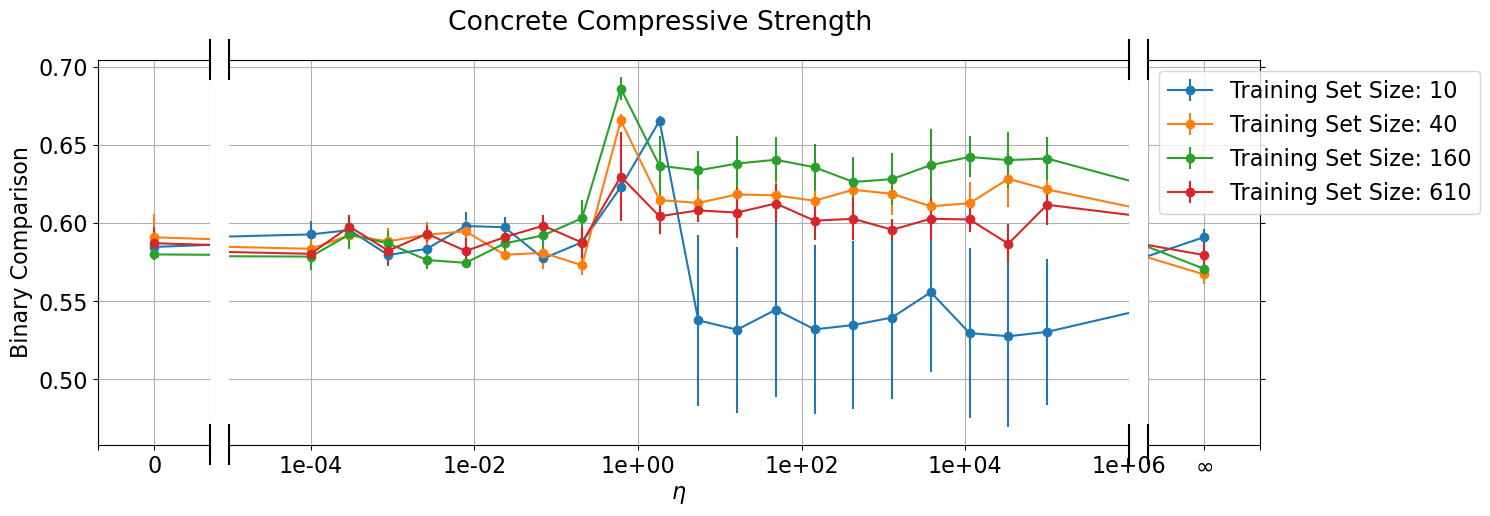

Cross-validation sses: [0.5871999999999999, 0.5803999999999999, 0.5978, 0.5824, 0.5932, 0.5822, 0.591, 0.5984, 0.5875999999999999, 0.6298, 0.6044, 0.6082, 0.6068, 0.6126, 0.6015999999999999, 0.6028, 0.5958, 0.6027999999999999, 0.6024, 0.5868, 0.6118, 0.5795999999999999]
Mean sse: 0.5975272727272727


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

print(binary_comparisons)

very_high_number = 10  # Replace this with an appropriate value for infinity
very_low_number = -10  # Replace this with an appropriate value for 0

# Function to format the tick labels
def sci_notation(tick_val, pos):
    if tick_val == very_low_number:
        return r''
    elif tick_val == very_high_number:
        return r''
    else:
        return f"{10**tick_val:.0e}"
def inf_zero_formatter(tick_val, pos):
    if tick_val == very_low_number:
        return r'$0$'
    elif tick_val == very_high_number:
        return r'$\infty$'
    else:
        return f''

# Create a loop that iterates over datasets
for p_index, dataset in enumerate(uci_datasets):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5), gridspec_kw={'width_ratios': [.1, .8, .1]})
    fig.suptitle(f'Concrete Compressive Strength')
    plt.subplots_adjust(wspace=0.05)


    # Loop over all_results and print a scatter plot with lambda (1/(eta ** 4)) on the x-axis and the mean binary_comparisons on the y-axis for each training set size
    for training_set_value in training_set_values:
        etas = list(binary_comparisons[training_set_value].keys())
        binary_comparison_means = [np.mean(binary_comparisons[training_set_value][eta]) for eta in etas]
        binary_comparison_se = [np.std(binary_comparisons[training_set_value][eta]) / np.sqrt(len(binary_comparisons[training_set_value][eta])) for eta in etas]

        print('Graphed Values')
        print(f"Training Set Size: {training_set_value}")
        print(binary_comparison_means)
        print(binary_comparison_se)

        # Separate etas and their corresponding means and errors
        normal_etas = [eta for eta in etas if eta != 0 and eta != np.inf]
        log_normal_etas = np.log10(normal_etas)
        normal_means = [binary_comparison_means[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]
        normal_se = [binary_comparison_se[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]

        # Insert eta=0 and eta=np.inf into the lists with their positions
        if 0 in etas:
            zero_idx = etas.index(0)
            log_normal_etas = np.insert(log_normal_etas, 0, very_low_number)
            normal_means.insert(0, binary_comparison_means[zero_idx])
            normal_se.insert(0, binary_comparison_se[zero_idx])
        if np.inf in etas:
            inf_idx = etas.index(np.inf)
            log_normal_etas = np.append(log_normal_etas, very_high_number)
            normal_means.append(binary_comparison_means[inf_idx])
            normal_se.append(binary_comparison_se[inf_idx])

        # Plot the results for normal etas including eta=0 and eta=inf
        ax1.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
        ax2.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
        ax3.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")

    # Set axis limits and labels
    ax1.set_xlim(left=very_low_number-1, right=very_low_number+1)  # Adjust as needed to create space around 0
    ax2.set_xlim(left=log_normal_etas[1]-1, right=log_normal_etas[-2]+1)  # Adjust as needed to create space around infinity
    ax3.set_xlim(left=very_high_number-1, right=very_high_number+1)  # Adjust as needed to create space around infinity
    ax2.set_xlabel(r'$\eta$')
    ax1.set_ylabel('Binary Comparison')
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax3.legend()
    
    # Use the custom formatter for the x-axis
    ax1.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))
    ax2.xaxis.set_major_formatter(FuncFormatter(sci_notation))
    ax3.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))

    # Hide the right spines of ax1 and the left spines of ax2
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.tick_params(left = False) 
    ax3.yaxis.tick_right()

    
    # Draw small vertical lines to indicate the break
    line_length = 0.05  # Length of the vertical lines

    # Top and bottom lines at the right edge of ax1
    ax1.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot([1, 1], [0 - line_length, line_length], transform=ax1.transAxes, color='k', clip_on=False)

    # Top and bottom lines at the left edge of ax2
    ax2.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot([0, 0], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

    # Top and bottom lines at the right edge of ax2
    ax2.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot([1, 1], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

    # Top and bottom lines at the left edge of ax3
    ax3.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax3.transAxes, color='k', clip_on=False)
    ax3.plot([0, 0], [0 - line_length, line_length], transform=ax3.transAxes, color='k', clip_on=False)

    plt.show()

    print("Cross-validation sses:", binary_comparison_means)
    print("Mean sse:", np.mean(binary_comparison_means))